In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from tqdm.auto import tqdm
import concurrent.futures
from multiprocessing import Pool
import copy,os,sys,psutil
from collections import Counter,deque
import  matplotlib.pyplot as plt
import pickle

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [3]:
# floatx默认是float32的，np里的都是64，直接都搞成64省事 
# 不行，会影响诸如 tf.keras.metrics.AUC 这样的API
# tf.keras.backend.set_floatx('float64')

# Data

load tfrecords
```
advertiser_id, campaign_id, group_id, creative_id, creative_tag, ad_style, bid_price, display_url, marketing_type, province_id, city_id
```

## tfrecord

In [ ]:
base_dir="/home/zhoutong/data/apus_ad/hc"
app2hash_fp=base_dir+"/ad_hc_2020-04-22_app2hash.txt"
info_fp = base_dir+"/ad_hc_2020-04-22_info.json"
# trd_gz_fp = base_dir +"/ad_hc_2020-04-22.trd.gz"
trd_gz_fp_list = [base_dir + i for i in ["/ad_hc_2020-04-21.trd.gz","/ad_hc_2020-04-22.trd.gz"]]

In [ ]:
with open(info_fp,"r") as fr:
    info=json.load(fr)
with open(app2hash_fp,"r") as fr:
    hash2app = dict([i.strip("\n").split("\t")[::-1] for i in fr.readlines()])

In [ ]:
print(info['count'])
info['detail'].keys()
str_fields=info['detail']['string']
double_fields=info['detail']['double']
arr_int_fields=info['detail']['array<int>']
long_fields=info['detail']['bigint']  # 时间戳 暂时不用，应该在spark里做一下解析
int_fields=info['detail']['int']

In [ ]:
# one_hot_fields=["device_id_s"]
# multi_hot_fields=["class_id_topN"]
# dense_fields=["download_num_mid"]
feature_desc = {}
# onehot
for f in str_fields:
    feature_desc.update({f:tf.io.FixedLenFeature([], tf.string, default_value='')})
# multi_hot
for f in arr_int_fields:
    feature_desc.update({f:tf.io.VarLenFeature(dtype=tf.int64)})
# dense / numeric
for f in double_fields:
    feature_desc.update({f:tf.io.FixedLenFeature([],dtype=tf.float32,default_value=0)})
for f in int_fields:
    feature_desc.update({f:tf.io.FixedLenFeature([],dtype=tf.int64,default_value=0)})

def _parse_func(inp):
    return tf.io.parse_single_example(inp,feature_desc)



trd=tf.data.TFRecordDataset(trd_gz_fp_list,compression_type='GZIP').map(_parse_func)
for i in trd.take(2):
    print(i)
dataset=trd.shuffle(5*128).batch(128,drop_remainder=True)

## Criteo 60k

In [18]:
###############################
# 随机构造两个multihot特征
###############################
base_dir="/home/zhoutong/notebook_collection/tmp/CTR"
df_total_iter=pd.read_csv(os.path.join(base_dir,"criteo_data_sampled_60k.csv"), chunksize=1000)
for idx,chunk in tqdm(enumerate(df_total_iter),total=60*10000/1000):
    m1 = []
    for i in range(chunk.shape[0]):
        # 随机 0~100 长度的list，list内的元素是 0~2000 注意str化
        random_size = np.random.randint(low=0,high=100+1)
        m1.append(np.random.randint(low=0,high=2000+1,size=random_size).astype(str))
    chunk['C27'] = m1
    m2 = []
    for i in range(chunk.shape[0]):
        # 随机 0~20 长度的list，list内的元素是 0~100 注意str化
        random_size = np.random.randint(low=0,high=20+1)
        m2.append(np.random.randint(low=0,high=100+1,size=random_size).astype(str))
    chunk['C28'] = m2
    # 处理下list型的数据方便csv读取
    chunk['C27'] = chunk['C27'].apply(lambda row: "["+",".join(row)+"]")
    chunk['C28'] = chunk['C28'].apply(lambda row: "["+",".join(row)+"]")
    if idx == 0:
        chunk.to_csv(os.path.join(base_dir,"criteo_data_sampled_60k_add_multihot_C27C28.csv"),header=True)
    else:
        chunk.to_csv(os.path.join(base_dir,"criteo_data_sampled_60k_add_multihot_C27C28.csv"),mode='a',header=False)

In [19]:
base_dir="/home/zhoutong/notebook_collection/tmp/CTR"
data_fp=os.path.join(base_dir,"criteo_data_sampled_60k_add_multihot_C27C28.csv")

print("[data_fp]: "+data_fp)

[data_fp]: /home/zhoutong/notebook_collection/tmp/CTR/criteo_data_sampled_60k_add_multihot_C27C28.csv


### 数据观察

部分数据观察

In [7]:
# 正负样本比: 0.254237288=1.5w/(4.4w+1.5w)
df_head10 = pd.read_csv(data_fp, nrows=10)
df_head10.head()
num_feat=[i for i in df_head10.columns if i.startswith("I")]
cat_feat=[i for i in df_head10.columns if i.startswith("C")]
print("[num_feat]: "+ ",".join(num_feat))
print("[cat_feat]: "+ ",".join(cat_feat))
df_head10.groupby("label").agg({"label":"count"})

,Unnamed: 0,label,I1,I2,I3,I4,I5,I6,I7,I8,...,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28
0,0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,...,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16,['1538' '131' '1968' '1534' '1129' '409' '1411...,['16' '82' '96' '74' '23' '50' '92' '97' '11' ...
1,1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,...,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655,['1131' '567' '440' '658' '1523' '1380' '106' ...,['16' '91' '46' '71' '82' '14' '68' '9' '19' '...
2,2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,...,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN,['397' '235'],['72' '69' '48' '59' '22' '10' '97' '40']
3,3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,...,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN,['13' '1825' '581' '33' '480' '1472' '209' '29...,['13' '14' '29']
4,4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,...,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN,[],['76']


[num_feat]: I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
[cat_feat]: C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28


,label
label,
0,9
1,1


全量数据观察

In [8]:
df_total=pd.read_csv(data_fp, nrows=600000)
df_total[num_feat].describe()
df_total[num_feat].count()
df_total[cat_feat].describe()
print("所有category特征合计: ",df_total[cat_feat].describe().loc['unique',:].sum())
print(">>> 注意以下的特征unique计数，是排除了NA的")
df_total[cat_feat].describe().loc['unique',:].T
df_total.groupby("label").agg({"label":"count"})

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
count,346447.000000,600000.000000,457859.000000,445879.000000,5.834030e+05,465077.000000,575030.000000,599558.000000,575030.000000,346447.000000,575030.000000,138927.000000,445879.000000
mean,3.304289,90.312038,24.093289,6.928496,1.837511e+04,120.356068,15.182599,13.469112,109.466894,0.567423,2.574685,0.882348,8.019404
std,9.324775,338.160418,422.394668,8.771655,6.668164e+04,504.611822,59.915704,40.027898,227.472589,0.683658,4.977896,6.230309,44.766028
min,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,7.710000e+02,8.000000,1.000000,2.000000,11.000000,0.000000,0.000000,0.000000,2.000000
50%,1.000000,2.000000,5.000000,4.000000,2.521000e+03,33.000000,3.000000,8.000000,40.000000,0.000000,1.000000,0.000000,4.000000
75%,3.000000,32.000000,14.000000,9.000000,1.033200e+04,103.000000,11.000000,20.000000,113.000000,1.000000,3.000000,0.000000,9.000000
max,780.000000,18522.000000,65535.000000,507.000000,2.513122e+06,233523.000000,8807.000000,5064.000000,12661.000000,8.000000,133.000000,768.000000,6702.000000


I1     346447
I2     600000
I3     457859
I4     445879
I5     583403
I6     465077
I7     575030
I8     599558
I9     575030
I10    346447
I11    575030
I12    138927
I13    445879
dtype: int64

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28
count,600000,600000,577541,577541,600000,522807,600000,600000,600000,600000,...,311065,311065,577541,148521,600000,577541,311065,311065,600000,600000
unique,1090,527,207578,85910,246,13,10358,512,3,25179,...,1748,3,160351,14,15,32095,63,24430,590109,523708
top,05db9164,38a947a1,d032c263,c18be181,25c83c98,7e0ccccf,7195046d,0b153874,a73ee510,3b08e48b,...,21ddcdc9,a458ea53,723b4dfd,ad3062eb,32c7478e,3fdb382b,001f3601,49d68486,[],[]
freq,300847,70536,18669,24638,403302,222429,11032,356658,537406,125744,...,179227,116724,20886,92953,236553,36206,79366,26357,5867,28521


所有category特征合计:  1999489
>>> 注意以下的特征unique计数，是排除了NA的


C1       1090
C2        527
C3     207578
C4      85910
C5        246
C6         13
C7      10358
C8        512
C9          3
C10     25179
C11      4556
C12    177153
C13      3041
C14        26
C15      8135
C16    139002
C17        10
C18      3614
C19      1748
C20         3
C21    160351
C22        14
C23        15
C24     32095
C25        63
C26     24430
C27    590109
C28    523708
Name: unique, dtype: object

,label
label,
0,446178
1,153822


### 获取featureMap
全量数据60w太大，直接做get_dummies可以用sparse=True
- 一来偶尔会跑不出来，推测是压力太大速度太慢（跑太久了手动停了）；
- 二来后续输入tf中，目前已知的只有.values的方案，这无异于把整个df都重新dense化了；

这里用自定义的方案，按chunksize过一遍全体数据，拿到featuremap后，手动做sparseTensor

In [ ]:
# 全量直接做get_dummies容易卡死
df_sparse=pd.get_dummies(df_total,sparse=True)
df_sparse
df_sparse.dtypes
# "{:.4f} mb".format(df_sparse.memory_usage().sum()/1e6)

In [23]:
# 自行遍历构造featureMap
chunksize=1000
fn_split2list=lambda x:[i for i in x.strip("[]").split(",") if i != ""]
df_total_iter=pd.read_csv(data_fp, chunksize=chunksize,converters={"C27":fn_split2list,"C28":fn_split2list})
num_feat=[]
cat_feat=[]
cat_featureMap={}
multihot_feat=["C27","C28"]
for idx,chunk in tqdm(enumerate(df_total_iter),total=60*10000/chunksize):
#     ###############################
#     # 随机构造两个multihot特征
#     ###############################
#     m1 = []
#     for i in range(chunk.shape[0]):
#         # 随机 0~100 长度的list，list内的元素是 0~2000 注意str化
#         random_size = np.random.randint(low=0,high=100+1)
#         m1.append(np.random.randint(low=0,high=2000+1,size=random_size).astype(str))
#     chunk['C27'] = m1
#     m2 = []
#     for i in range(chunk.shape[0]):
#         # 随机 0~20 长度的list，list内的元素是 0~100 注意str化
#         random_size = np.random.randint(low=0,high=20+1)
#         m2.append(np.random.randint(low=0,high=100+1,size=random_size).astype(str))
#     chunk['C28'] = m2

    ###############################
    # 提取numeric特征和category特征
    ###############################
    _num_feat=[i for i in chunk.columns if i.startswith("I")]
    _cat_feat=[i for i in chunk.columns if i.startswith("C")]
    if len(num_feat) > 0:
        assert num_feat == _num_feat,f"I系特征不符，前{idx*chunksize}条为: {num_feat}，此后为{_num_feat}"
    else:
        num_feat = _num_feat
    if len(cat_feat) > 0:
        assert cat_feat == _cat_feat,f"C系特征不符，前{idx*chunksize}条为: {cat_feat}，此后为{_cat_feat}"
    else:
        cat_feat = _cat_feat
    
    #############################
    # category特征构造出featureMap
    #############################
    for feat in cat_feat:
#         features=list(chunk[feat].unique())
        features=list(np.unique(np.hstack(chunk[feat].values.flat)))
        features_ori=cat_featureMap.get(feat,[])
        cat_featureMap.update({feat: list(set(features+features_ori))})
    
for k,v in cat_featureMap.items():
    print(f"k:{k}, cnt:{len(v)}")

cat_featureSize=sum([len(v) for k,v in cat_featureMap.items()])
print("所有的category特征总计: {}".format(cat_featureSize))

before=0
cat_featureIdx_beginAt={}
for k,v in cat_featureMap.items():
    cat_featureIdx_beginAt.update({k:before})
    before += len(v)
print("各category特征的起始索引:")
cat_featureIdx_beginAt


k:C1, cnt:1090
k:C2, cnt:527
k:C3, cnt:207579
k:C4, cnt:85911
k:C5, cnt:246
k:C6, cnt:14
k:C7, cnt:10358
k:C8, cnt:512
k:C9, cnt:3
k:C10, cnt:25179
k:C11, cnt:4556
k:C12, cnt:177154
k:C13, cnt:3041
k:C14, cnt:26
k:C15, cnt:8135
k:C16, cnt:139003
k:C17, cnt:10
k:C18, cnt:3614
k:C19, cnt:1749
k:C20, cnt:4
k:C21, cnt:160352
k:C22, cnt:15
k:C23, cnt:15
k:C24, cnt:32096
k:C25, cnt:64
k:C26, cnt:24431
k:C27, cnt:2001
k:C28, cnt:101
所有的category特征总计: 887786
各category特征的起始索引:


{'C1': 0,
 'C2': 1090,
 'C3': 1617,
 'C4': 209196,
 'C5': 295107,
 'C6': 295353,
 'C7': 295367,
 'C8': 305725,
 'C9': 306237,
 'C10': 306240,
 'C11': 331419,
 'C12': 335975,
 'C13': 513129,
 'C14': 516170,
 'C15': 516196,
 'C16': 524331,
 'C17': 663334,
 'C18': 663344,
 'C19': 666958,
 'C20': 668707,
 'C21': 668711,
 'C22': 829063,
 'C23': 829078,
 'C24': 829093,
 'C25': 861189,
 'C26': 861253,
 'C27': 885684,
 'C28': 887685}

### 特征工程

In [25]:
chunk.head(5)

,Unnamed: 0,label,I1,I2,I3,I4,I5,I6,I7,I8,...,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28
599000,599000,1,1.0,-1,NaN,NaN,1380.0,22.0,7.0,23.0,...,NaN,NaN,723b4dfd,NaN,bcdee96c,b34f3128,NaN,NaN,"[1163, 117, 288, 48, 1367, 1606, 1647, 1455, 1...","[73, 84, 35, 78, 11, 77, 9, 48, 89, 3, 47, 78,..."
599001,599001,1,12.0,0,1.0,NaN,583.0,0.0,12.0,29.0,...,21ddcdc9,5840adea,7288f4fc,NaN,32c7478e,6c1cdd05,ea9a246c,1219b447,"[1016, 867, 812, 426, 1840, 31, 1446, 729, 174...","[81, 67, 74, 31, 61, 21, 49, 33, 58, 2, 55]"
599002,599002,0,NaN,-1,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,e9e8dae4,NaN,32c7478e,be42b2ff,NaN,NaN,"[1694, 448, 351, 1549, 1874, 990, 707, 927, 13...","[82, 8, 11, 67, 23, 23, 59, 42]"
599003,599003,1,6.0,59,9.0,18.0,1.0,3.0,8.0,20.0,...,NaN,NaN,NaN,ad3062eb,dbb486d7,NaN,NaN,NaN,"[292, 1988, 1204, 129, 1665, 1535, 194, 1399, ...","[76, 7, 66, 70, 69, 92, 33, 44, 16, 15, 52, 73..."
599004,599004,0,NaN,0,76.0,8.0,2.0,158.0,5.0,12.0,...,21ddcdc9,a458ea53,d83181ad,NaN,32c7478e,3fdb382b,9b3e8820,25bf05c2,"[925, 1751, 581, 928, 1955, 880, 1592, 1037, 1...","[31, 31, 46, 92, 27, 38, 13, 27, 56, 38, 63, 3..."


In [61]:
def normalize(df_inp,num_fields):
    """
    连续特征归一化
    """
    df=df_inp.copy()
    max_records=df[num_fields].apply(np.max,axis=0)
    min_records=df[num_fields].apply(np.min,axis=0)
    denominator=(max_records-min_records).apply(lambda x: x if x!=0 else 1e-4) 
    for f in num_fields:
        df[f] = df[f].apply(lambda x: np.abs(x-min_records[f])/denominator[f])
    return df


def fill_numeric_NA(df_inp,num_fields):
    """
    连续特征的NA填充 | 暂时直接用均值填充
    """
    df=df_inp.copy()
    df_numeric_part=df[num_fields]
    df[num_fields]=df_numeric_part.fillna(df_numeric_part.mean())
    return df

def map_cat_to_idx(chunk,cat_feat_=cat_feat,multihot_feat_=multihot_feat,cat_featureMap_=cat_featureMap,cat_featureIdx_beginAt_=cat_featureIdx_beginAt):
    """
    根据featureMap来进行映射
    效率上存在问题，1k数据&26个onehot特征&2个multihot，cat_featureMap有88w，耗时约 35s
    """
    chunk_=chunk.copy()
    for feat in cat_feat_:
        values = cat_featureMap_[feat]
        begin_idx = cat_featureIdx_beginAt_[feat]
        if feat in multihot_feat_:
            chunk_[feat]=chunk_[feat].apply(lambda x: [values.index(str(i))+begin_idx for i in x])
        else:
            chunk_[feat]=chunk_[feat].apply(lambda x: values.index(str(x))+begin_idx)
    return chunk_

# df=normalize(df_head10,num_feat)
df=normalize(chunk,num_feat)
df=fill_numeric_NA(df,num_feat)
df=map_cat_to_idx(df)
df_featured=df
df_featured.head(5)

,Unnamed: 0,label,I1,I2,I3,I4,I5,I6,I7,I8,...,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28
5000,5000,0,0.000000,0.128808,0.000155,0.003571,0.002320,0.074846,0.093596,0.387755,...,668566,668709,774120,829072,829081,847485,861252,880253,"[886184, 886947, 886996, 885897, 885800, 88734...","[887748, 887725, 887694, 887757, 887702, 88770..."
5001,5001,0,0.000000,0.000204,0.000039,0.030346,0.002878,0.002058,0.001642,0.061224,...,668061,668708,736377,829072,829081,855091,861252,882266,"[886382, 887525, 887174, 885819, 886979, 88649...","[887729, 887745, 887750, 887701, 887785, 88769..."
5002,5002,1,0.050136,0.021468,0.002468,0.030346,0.013773,0.005658,0.029557,0.081633,...,668650,668710,757975,829072,829081,838740,861218,874925,"[887423, 887138, 887631, 885693, 885782, 88661...","[887729, 887702, 887706, 887758, 887744, 88775..."
5003,5003,0,0.000000,0.010427,0.000039,0.003571,0.002350,0.057356,0.016420,0.551020,...,668551,668709,771564,829072,829088,840450,861199,866884,"[886541, 886083, 887057, 886490, 885778, 88593...","[887705, 887762, 887689]"
5004,5004,1,0.014706,0.004294,0.001082,0.078571,0.000000,0.000000,0.016420,0.408163,...,668551,668709,778510,829072,829081,858137,861252,861432,"[886950, 887159, 885953, 887231, 886090, 88765...","[887721, 887701, 887734, 887717, 887750, 88778..."


### 持久化到本地 | 特征工程结果验证无误

In [52]:
#################
# 持久化各种infos
#################
with open(os.path.join(base_dir,"cat_featureMap.pkl"),"wb") as fwb:
    pickle.dump(cat_featureMap, fwb)
    
with open(os.path.join(base_dir,"cat_featureIdx_beginAt.pkl"),"wb") as fwb:
    pickle.dump(cat_featureIdx_beginAt, fwb)


In [ ]:
####################
# 持久化特征工程后的结果
####################
chunksize=10000
fn_split2list=lambda x:[i for i in x.strip("[]").split(",") if i != ""]
df_total_iter=pd.read_csv(os.path.join(base_dir,"criteo_data_sampled_60k_add_multihot_C27C28.csv"), chunksize=chunksize,converters={"C27":fn_split2list,"C28":fn_split2list})
for idx,chunk in tqdm(enumerate(df_total_iter),total=60*10000/chunksize):
    df=normalize(chunk,num_feat)
    df=fill_numeric_NA(df,num_feat)
    df=map_cat_to_idx(df)
    # 处理下list型的数据 方便csv
    df['C27']=df["C27"].apply(lambda x: "["+",".join([str(i) for i in x])+"]")
    df['C28']=df["C28"].apply(lambda x: "["+",".join([str(i) for i in x])+"]")
    if idx == 0 :
        df.to_csv(os.path.join(base_dir,"criteo_data_sampled_60k_add_multihot_C27C28_idx_processed.csv"),header=True)
    else:
        df.to_csv(os.path.join(base_dir,"criteo_data_sampled_60k_add_multihot_C27C28_idx_processed.csv"),mode='a',header=False)
data_fp = os.path.join(base_dir,"criteo_data_sampled_60k_add_multihot_C27C28_idx_processed.csv")

### 数据输入准备
分离label和两类特征

In [68]:
##########
# data_fp
##########
base_dir="/home/zhoutong/notebook_collection/tmp/CTR"
data_fp=os.path.join(base_dir,"criteo_data_sampled_60k_add_multihot_C27C28_idx_processed.csv")
print("[data_fp]: "+data_fp)

##################
# 3 kinds feature
##################
cat_feat=["C{}".format(i) for i in range(1,29)]
num_feat=["I{}".format(i) for i in range(1,14)]
onehot_feat=["C{}".format(i) for i in range(1,27)]
multihot_feat = ["C27","C28"]

##################
# load featureMap
##################
with open(os.path.join(base_dir,"cat_featureMap.pkl"),"rb") as frb:
    cat_featureMap = pickle.load(frb)
    
with open(os.path.join(base_dir,"cat_featureIdx_beginAt.pkl"),"rb") as frb:
    cat_featureIdx_beginAt = pickle.load(frb)

[data_fp]: /home/zhoutong/notebook_collection/tmp/CTR/criteo_data_sampled_60k_add_multihot_C27C28_idx_processed.csv


In [74]:
##########
# 检查数据
##########
fn_split2list=lambda x:[int(i) for i in x.strip("[]").split(",") if i != ""]
df_idx_ = pd.read_csv(data_fp,nrows=1000,converters={"C27":fn_split2list,"C28":fn_split2list})
df_idx_.head(2)
"{:.2f}KB".format(df_idx_.memory_usage().sum()/1e3)
label=df_idx_.pop("label").values
num_features=df_idx_[num_feat].values
cat_features=df_idx_[cat_feat].values
multihot_features=df_idx_[multihot_feat].values
onehot_features = df_idx_[list(set(cat_feat) - set(multihot_feat))].values

"label.shape",label.shape
"num_features.shape",num_features.shape
"onehot_features.shape",onehot_features.shape
"multihot_features.shape",multihot_features.shape

num_features[0]
onehot_features[0]
multihot_features[0]

,Unnamed: 0,Unnamed: 0.1,label,I1,I2,I3,I4,I5,I6,I7,...,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28
0,0,0,0,0.004673,0.000162,0.000076,0.000000,0.000854,0.000329,0.009047,...,668551,668709,769606,829072,829086,857204,861252,876597,"[886987, 887506, 887434, 886882, 886184, 88666...","[887764, 887733, 887727, 887747, 887774, 88770..."
1,1,1,0,0.009346,0.000108,0.000671,0.003571,0.000063,0.000658,0.001206,...,668551,668707,770188,829072,829086,834878,861252,869239,"[887144, 886246, 885716, 885981, 886583, 88588...","[887781, 887736, 887730, 887771, 887699, 88770..."


'352.13KB'

('label.shape', (1000,))

('num_features.shape', (1000, 13))

('onehot_features.shape', (1000, 26))

('multihot_features.shape', (1000, 2))

array([4.67289720e-03, 1.61952062e-04, 7.62951095e-05, 0.00000000e+00,
       8.54081794e-04, 3.28758116e-04, 9.04704463e-03, 2.93255132e-03,
       2.46762100e-02, 1.66666667e-01, 2.53164557e-02, 9.12285444e-03,
       2.59740260e-03])

array([295108, 323633, 861252, 666517, 235361, 335457, 668551, 305911,
       829086,    605,   1259, 876597, 513238, 663340, 499124, 524302,
       573615, 295357, 668709, 857204,  99905, 306239, 516182, 829072,
       769606, 301655])

array([list([886987, 887506, 887434, 886882, 886184, 886666, 887514, 886356, 885693, 887081, 886415, 887416, 887247, 886244, 886982, 885772, 887670, 887295, 887482, 887201, 886954, 887494, 886973, 887250, 887186, 887408, 887545, 886883, 886870, 887652, 887506, 886444, 885795, 885906, 887402, 886843, 886049, 886083, 886996, 886941, 885942, 886531, 886058, 886957, 885891, 885878, 887598, 886440, 886351, 887076, 886498, 886326, 886597, 886773, 886696, 886316, 886533, 887139, 886347, 885876, 887518, 886761, 886882, 885773, 887142, 886932, 886555, 887018, 887218, 886584, 887489, 886152, 887611, 887310, 886084, 886148]),
       list([887764, 887733, 887727, 887747, 887774, 887701, 887723, 887760, 887785, 887744, 887708])],
      dtype=object)

### 直接来一手持久化

Deprecated

In [34]:
import pickle

with open(os.path.join(base_dir,"num_features.pkl"),"wb") as fwb:
    pickle.dump(num_features,fwb)
    
with open(os.path.join(base_dir,"onehot_features.pkl"),"wb") as fwb:
    pickle.dump(onehot_features,fwb)
    
with open(os.path.join(base_dir,"multihot_features.pkl"),"wb") as fwb:
    pickle.dump(multihot_features,fwb)

In [35]:
import pickle
with open(os.path.join(base_dir,"num_features.pkl"),"rb") as frb:
    num_features = pickle.load(frb)
    
with open(os.path.join(base_dir,"onehot_features.pkl"),"rb") as frb:
    onehot_features = pickle.load(frb)
    
with open(os.path.join(base_dir,"multihot_features.pkl"),"rb") as frb:
    multihot_features = pickle.load(frb)
num_features
onehot_features
multihot_features

array([[1.53846154e-02, 0.00000000e+00, 6.38992274e-02, ...,
        2.52100840e-02, 1.99901039e-02, 4.80324074e-02],
       [1.84615385e-01, 1.64149705e-04, 5.43478261e-03, ...,
        2.52100840e-02, 0.00000000e+00, 4.80324074e-02],
       [4.91955757e-02, 0.00000000e+00, 6.38992274e-02, ...,
        2.22610783e-02, 1.99901039e-02, 4.80324074e-02],
       ...,
       [0.00000000e+00, 9.84898227e-04, 5.43478261e-03, ...,
        8.40336134e-03, 1.99901039e-02, 1.48148148e-02],
       [4.91955757e-02, 9.84898227e-04, 3.91304348e-01, ...,
        0.00000000e+00, 1.99901039e-02, 5.92592593e-02],
       [0.00000000e+00, 1.64149705e-04, 2.60869565e-01, ...,
        8.40336134e-03, 1.99901039e-02, 8.88888889e-02]])

array([[516181,    552, 353839, ..., 334459, 843101, 668078],
       [516181,    613, 466610, ..., 332551, 842456, 668456],
       [516184,     66, 491129, ..., 332844, 844500, 668078],
       ...,
       [516181,    613, 412619, ..., 335686, 843552, 668078],
       [516181,      0, 347434, ..., 333260, 830823, 667481],
       [516181,   1013, 453530, ..., 334983, 836088, 667710]])

array([[list([886409, 887083, 886588, 886092, 886012, 886741, 886918, 887480, 886552, 887318, 887127, 886991, 887251, 887440, 886011, 886273, 887117, 885837, 886149, 886841, 887650, 887485, 886257, 886508, 887550, 887497, 887009, 885789, 886473, 886630, 885844, 886094, 886699, 887186, 887494, 886304, 886728, 887603, 886537, 887292, 886464, 887040, 886442, 886420, 886488, 887579, 886985, 887483, 885906, 887223, 886478, 885948, 886251, 887100, 887463, 886554, 886193, 885951, 885830, 887592, 885767, 886023, 887411, 887211, 886704, 887222, 886586]),
        list([887692, 887744, 887715, 887740, 887739, 887755, 887729, 887758, 887768, 887717, 887761, 887746])],
       [list([886246]),
        list([887781, 887693, 887767, 887723, 887772, 887767, 887756, 887723, 887766, 887728, 887725, 887725, 887740, 887712, 887752, 887719])],
       [list([886628, 887644, 886896, 886784, 886425, 886441, 887358, 886355, 887393, 886790, 886251, 886701, 887294, 886426, 887569, 885749, 887231, 887348, 887477, 

# Model 草稿

单独说明下tf里几个乘法
- tf.tensordot
    - 用`axes`参数用来表示两个待计算的元素哪一维是一致的
        - (M,N) 和 (N,P) 相乘那就是 axes=1 表示第一个元素的第1维
        ```python
        >>> x1=np.arange(3).reshape(1,3)
        x1: array([[0, 1, 2]])
        >>> x2=np.arange(9).reshape(3,3)
        x2: array([[0, 1, 2],
                   [3, 4, 5],
                   [6, 7, 8]])
        >>> dotted=tf.tensordot(x1,x2,axes=1).numpy()
        dotted: array([[15, 18, 21]])
        >>> x1.shape,x2.shape,dotted.shape
        res: ((1, 3), (3, 3), (1, 3))
        ```
        - (B,M,N) 和 (B,N,P) 相乘那就是 axes=[[2],[1]] 表示第一个元素的第2维和第二个元素的第1维
        ```python
        >>> x1=np.arange(3).reshape(1,1,3)
        x1: array([[[0, 1, 2]]])
        >>> x2=np.arange(9).reshape(1,3,3)
        x2: array([[[0, 1, 2],
                    [3, 4, 5],
                    [6, 7, 8]]])
        >>> dotted=tf.tensordot(x1,x2,axes=[[2],[1]]).numpy()
        dotted: array([[[[15, 18, 21]]]])
        >>> x1.shape,x2.shape,dotted.shape
        res: ((1, 1, 3), (1, 3, 3), (1, 1, 1, 3))
        ```
    - 要求相乘的元素数据类型一致

- tf.keras.backend.dot
    - 这个是做矩阵乘法的，需要满足两个输入是 MxQ QxN 的shape关系
    - 要求相乘的元素数据类型一致
```python
>>> tf.keras.backend.dot(tf.constant([[1,0,0]]), tf.constant([[1],[2],[3]])).numpy()
array([[1]], dtype=int32)
```
- tf.keras.layers.Dot
    - 比较复杂，是通过初始化时的`axes`来控制计算时取哪个（或哪几个）维度去做点积——对应idx的元素乘起来最后加和
    - 其实和`tf.tensordot`的`axes`是一样的
    - tf官方文档的例子已经很清楚了 https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot

单独说明一下两个方法涉及 稀疏向量和稠密向量 计算的API（实际都是矩阵相乘）
- tf.nn.embedding_lookup_sparse
    - 相比于`tf.nn.embedding_lookup`就是多了个`combiner`来做合并
        - 注：`tf.nn.embedding_lookup`和`tf.gather`逻辑是一样的，实现上前者的目的是为了支持更大向量（做了partition），见[文档](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup)
    - 实际是查表然后把向量用`combiner`指定的方式“加和”
    - `sp_ids`的values指定取哪个位置的emb向量,其indices不影响结果
    - `sp_weights` 指定该emb向量乘某个权重，一般为None，即乘1
    - `combiner` 选择加和的方式 "mean" "sqrtn" "sum"
    - 注意它的`sp_ids`参数要求是SparseTensor，而SparseTensor构造的时候实际是二维的矩阵，如下示例演示"查前三个emb的均值"
    ```python
    >>> sp_ids_a=tf.sparse.SparseTensor(indices=[[0,0],[0,1],[0,2]],values=[0,1,2],dense_shape=[1,5])
    >>> tf.sparse.to_dense(sp_ids_a).numpy()
    array([[0, 1, 2, 0, 0]], dtype=int32)
    >>> sp_ids_b=tf.sparse.SparseTensor(indices=[[0,0],[0,3],[0,4]],values=[0,1,2],dense_shape=[1,5])
    >>> tf.sparse.to_dense(sp_ids_b).numpy()
    array([[0, 0, 0, 1, 2]], dtype=int32)
    >>> emb=tf.Variable(name='emb',initial_value=tf.keras.initializers.GlorotUniform(seed=2020)((cat_featureSize,4)))
    >>> emb.numpy()
    array([[-1.0650440e-03, -1.0466943e-03, -6.1871600e-04, -1.7025521e-03],
           [-2.6915036e-04, -7.1870629e-05,  1.8417728e-03,  2.2394117e-03],
           [-2.0872806e-03, -3.6849058e-04,  1.8430836e-03,  1.1817920e-03],
           ...,
           [ 1.2313656e-03,  1.6786391e-04, -2.4000034e-03,  1.8373653e-03],
           [ 3.2466953e-04, -1.6028697e-03,  7.8225043e-05, -1.4092607e-03],
           [ 2.4349121e-03, -7.7580218e-04, -1.6710395e-03,  5.3080427e-04]],
          dtype=float32)
    >>> tf.nn.embedding_lookup_sparse(params=emb,sp_ids=sp_ids_a,sp_weights=None,combiner="mean").numpy()
    array([[-0.00114049, -0.00049569,  0.00102205,  0.00057288]],dtype=float32)
    >>> tf.nn.embedding_lookup_sparse(params=emb,sp_ids=sp_ids_b,sp_weights=None,combiner="mean").numpy()
    array([[-0.00114049, -0.00049569,  0.00102205,  0.00057288]],dtype=float32)
    >>> (emb[0]+emb[1]+emb[2]).numpy()/3
    array([-0.00114049, -0.00049569,  0.00102205,  0.00057288], dtype=float32)
    ```
    
- `tf.sparse.sparse_dense_matmul`
    - 这个是完全的矩阵相乘的逻辑，要求数据类型一致，要求是 MxN NxP 的shape关系
    - 下面这个例子，相当于拿[0.5,1,2,0]和80w个emb向量做了点积
    ```pythonn
    >>> sp_ids_c=tf.sparse.SparseTensor(indices=[[0,0],[0,1],[0,2]],values=[0.5,1.,2.],dense_shape=[1,4])
    >>> tf.sparse.to_dense(sp_ids_c).numpy()
    array([[0.5, 1. , 2. , 0. ]], dtype=float32)
    >>> tf.sparse.sparse_dense_matmul(sp_a=sp_ids_c,b=tf.transpose(emb)).numpy()
    array([[-0.00281665,  0.0034771 ,  0.00227404, ..., -0.00401646,
        -0.00128408, -0.00290043]], dtype=float32)
    >>> tf.sparse.sparse_dense_matmul(sp_a=sp_ids_c,b=tf.transpose(emb)).numpy().shape
    (1,885684)
    ```

In [210]:
sp_ids_b=tf.sparse.SparseTensor(indices=[[0,0],[1,3],[2,4]],values=[0,1,2],dense_shape=[4,10])
tf.sparse.to_dense(sp_ids_b).numpy()
pad_size = sp_ids_b.dense_shape[0] - 1 - tf.math.reduce_max(sp_ids_b.indices[:,0],axis=0)

tf.nn.embedding_lookup_sparse(params=emb,sp_ids=sp_ids_b,sp_weights=None,combiner="mean")

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-0.00337875, -0.00332054, -0.00196282, -0.00540119],
       [-0.00085385, -0.000228  ,  0.00584286,  0.00710433],
       [-0.00662171, -0.001169  ,  0.00584702,  0.00374913]],
      dtype=float32)>

## 几种实现方案
- [CTR预估模型：DeepFM/Deep&Cross/xDeepFM/AutoInt代码实战与讲解](https://zhuanlan.zhihu.com/p/109933924)
    - FM一阶特征结果1维
    - FM二阶特征结果1维 | 交叉乘积(emb1\*ebm2+emb2\*emb1)的结果(一个tensor)进行了reduce_sum
    - NN特征结果1维 | 3个Dense(256)+1个Dense(1)
    - 三个结果求和再过sigmoid
    
- [[带你撸论文]之Deep FM算法代码级精讲](https://zhuanlan.zhihu.com/p/109901389)
    - FM一阶特征结果1维
    - FM二阶特征结果emb维 | 保留交叉乘积的那个tensor
    - NN特征结果N维 | 最后一个FC层的大小
    - 三个结果concat再FC+sigmoid
    
- 连续特征处理
    - 可以是给field一个emb，然后用numeric的值乘这个emb
    - 也可以不过emb，直接concat在最后一FC前面（NN里的最后一个或者拼接后的最后一个FC）
- multi-hot特征处理
    - 一般就是取这几个emb的均值了
    
论文里的图 & 原文解释
- normal connection 是trainable的权重；
- weight-1 connection 是权重为1的直连；
- 中间用的activation是 relu 和 tanh
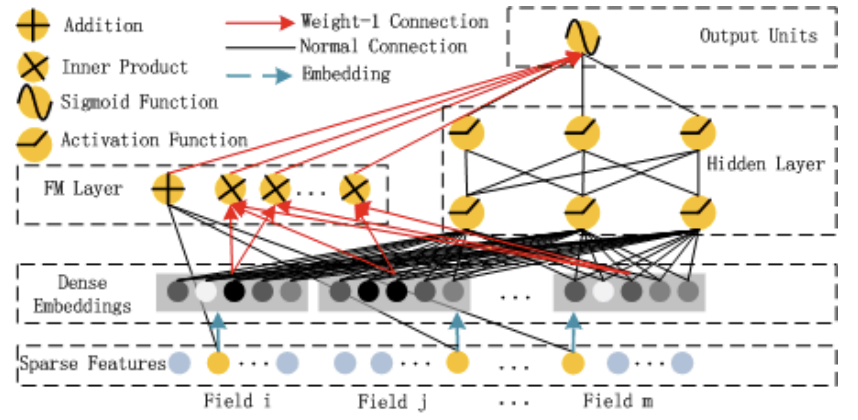


## FMLayer

In [18]:
class FMLayer(tf.keras.layers.Layer):
    def __init__(self, feature_size, emb_size=30, **kwargs):
        super().__init__(**kwargs)
        self.feature_size = feature_size
        self.emb_size = emb_size
        self.kernel_emb = self.add_weight(name='kernel_emb', 
                                          shape=(self.feature_size, self.emb_size),
                                          initializer='glorot_uniform',
                                          trainable=True)
        self.kernel_w = self.add_weight(name='kernel_w',
                                        shape=(self.feature_size,1),
                                        initializer='glorot_uniform',
                                        trainable=True)

    def build(self, input_shape):
        """
        重写build方法，在这里glorot初始化emb表
        改: FM的emb表和input_shape无关，还是不放在build里初始化了
        """
        super().build(input_shape)  
    
    def call(self, x):
        """
        x: 特征的索引矩阵;
        二阶特征: 索引查到各自的emb后，计算 <v1,v2>x1x2，这里实现时是 0.5*((emb1+emb2)^2 - emb1^2 - emb2^2)=emb1*emb2 
                 <emb1,emb2> != emb1*emb2 前者是内积得到的是标量，后者是element-wise的逐点相乘得到一个相同size的向量
        一阶特征: 直接根据idx查到权重w后求和，就是个LR
        """
        # 一阶特征
        x_1st_order = tf.reduce_sum(tf.nn.embedding_lookup(self.kernel_w,x),axis=1)
        # 二阶特征 | a*b+a*c+b*c
        x_emb = tf.nn.embedding_lookup(self.kernel_emb,x)
        x_square_of_sum = tf.square(tf.reduce_sum(x_emb,axis=1))  # (a+b+c)^2
        x_sum_of_square = tf.reduce_sum(tf.square(x_emb),axis=1)  # a^2 + b^2 + c^2
        x_2nd_order = 0.5*(x_square_of_sum - x_sum_of_square) # a*b+b*c+a*c
        x_2nd_order = tf.reduce_sum(x_2nd_order,axis=1,keepdims=True)
        fm_res = x_1st_order + x_2nd_order
        return fm_res

    def compute_output_shape(self, input_shape):
        """
        如 (100,10) 100个样本每个10个category特征，找到10个emb后取均值，返货结果就是 (100,emb_size)
        """
        return (input_shape[0], self.emb_size)
    
    @staticmethod
    def feature_idx_to_sparse_indices(arr):
        """
        把
        [[16,99,378,899],
         [12,89,103,500]]
        映射成:
        [[0,16],[0,99],[0,378],[0,899],
         [1,12],[1,89],[1,103],[1,500]] 
        用于给tf.sparse.SparseTensor提供indices参数，获得系数矩阵
        """
        return np.array([[[idx,v] for v in row] for idx,row, in enumerate(arr)]).reshape(arr.shape[0]*arr.shape[1],-1)

fml = FMLayer(feature_size=cat_featureSize,emb_size=4)

### FMLayer 计算拆解

FMLayer的call()计算流程

In [31]:
x.shape

(1000, 26)

In [33]:
x=onehot_features
x[:5,:5]
# 一阶特征
x_1st_order = tf.reduce_sum(tf.nn.embedding_lookup(fml.kernel_w,x),axis=1)
# 二阶特征 | a*b+a*c+b*c
x_emb = tf.nn.embedding_lookup(fml.kernel_emb,x)
x_square_of_sum = tf.square(tf.reduce_sum(x_emb,axis=1))  # (a+b+c)^2
x_sum_of_square = tf.reduce_sum(tf.square(x_emb),axis=1)  # a^2 + b^2 + c^2
x_2nd_order = 0.5*(x_square_of_sum - x_sum_of_square) # a*b+b*c+a*c
x_2nd_order = tf.reduce_sum(x_2nd_order,axis=1,keepdims=True)
x_1st_order.shape
x_2nd_order.shape
fm_res = x_1st_order + x_2nd_order
x_1st_order.numpy()[:2,:2]
x_2nd_order.numpy()[:2,:2]
fm_res.numpy()[:2,:2]

print(">>> 直接用FMLayers计算")
fml(x).numpy()[:2,:2]

array([[667900, 306239,   6390,    352, 306219],
       [667184, 306239, 127331,     35, 305797],
       [667900, 306238, 143041,    858, 306192],
       [667900, 306239,  81446,    515, 305797],
       [667184, 306239, 159179,    125, 306219]])

TensorShape([1000, 1])

TensorShape([1000, 1])

array([[ 0.00087078],
       [-0.01115316]], dtype=float32)

array([[-1.1000106e-05],
       [ 1.4646870e-05]], dtype=float32)

array([[ 0.00085978],
       [-0.01113851]], dtype=float32)

>>> 直接用FMLayers计算


array([[ 0.00085978],
       [-0.01113851]], dtype=float32)

演示FM里二阶的计算
- FM的理论把两个向量的内积作为权重，这两个向量就是每个cat特征的embedding
- 这个思路来自于矩阵分解的理论，对于正定矩阵W有W=V*VT
- 类似的也有attention里的QKV机制，认为Q、K的向量内积（点积）代表了二者的相似性
- 更类似的还有CF里 MxN的User-Item矩阵拆分成 MxK的User矩阵 和 KxN的Item矩阵，User矩阵xItem矩阵得到User-Item预测矩阵，这里没有交互的项也得到了计算值，接下来迭代User矩阵和Item矩阵，让User-Item预测矩阵中已经有交互行为的项接近真实值；
- FM的一阶和emb无关，就是普通的LR

In [34]:
# x = cat_features
# x = tf.nn.embedding_lookup(params=fml.kernel,ids=x)
# 假设两个样本，各自有三个onehot特征，查出来的4维emb如下，每个样本都是[a,b,c] 且 a,b,c 均是4维emb向量
x = np.array([[[1.0,2.0,3.0,4.0],[1.0,2.0,3.0,4.0],[10,10,10,10]],
              [[0.1,0.1,0.1,0.1],[0.1,0.2,0.3,0.4],[2.,2.,2.,2.]]])
x = tf.constant(x)
# (a+b+c)^2
x_square_of_sum = tf.square(tf.reduce_sum(x,axis=1))
# a^2 + b^2 + c^2
x_sum_of_square = tf.reduce_sum(tf.square(x),axis=1)
# FM二阶特征交叉 | a*b+a*c+b*c
x_2nd_order = (x_square_of_sum - x_sum_of_square)*0.5

x.numpy()
x_2nd_order.numpy()

array([[[ 1. ,  2. ,  3. ,  4. ],
        [ 1. ,  2. ,  3. ,  4. ],
        [10. , 10. , 10. , 10. ]],

       [[ 0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.2,  0.3,  0.4],
        [ 2. ,  2. ,  2. ,  2. ]]])

array([[21.  , 44.  , 69.  , 96.  ],
       [ 0.41,  0.62,  0.83,  1.04]])

## MultiFCLayer

In [35]:
class MultiFCLayers(tf.keras.layers.Layer):
    def __init__(self,layer_units,**kwargs):
        super().__init__(**kwargs)
        self.layer_units = layer_units
        for idx,unit in enumerate(layer_units):
            if idx == 0 :
                continue
            self.add_weight(name=f"layer_{idx}",shape=(layer_units[idx-1],unit),initializer="glorot_uniform",trainable=True)
    
    def build(self, input_shape):
        super().build(input_shape)
        self.layer0=self.add_weight(name="layer_0",shape=(input_shape[-1],self.layer_units[0]),initializer="glorot_uniform",trainable=True)
        self.weights_dict={weight.name.split(":")[0]:weight for weight in self.weights}
        
        
    def call(self,x):
        for idx,_ in enumerate(self.layer_units):
            x = tf.matmul(x,self.weights_dict[f'layer_{idx}'])
        x = tf.nn.sigmoid(x)
        return x
    

In [36]:
emb_size=8
nn_input_shape=(1000,onehot_features.shape[1]*emb_size+num_features.shape[1])
mfcl=MultiFCLayers([2,8,10])
mfcl.build(input_shape=nn_input_shape)
mfcl(np.random.random_sample(nn_input_shape).astype(np.float32))

<tf.Tensor: shape=(1000, 10), dtype=float32, numpy=
array([[0.35199943, 0.6199    , 0.7685603 , ..., 0.6185135 , 0.37059778,
        0.53648514],
       [0.4110737 , 0.6076109 , 0.6301485 , ..., 0.54391503, 0.4309518 ,
        0.5219093 ],
       [0.3889394 , 0.54813224, 0.74761254, ..., 0.6179316 , 0.39395842,
        0.5265904 ],
       ...,
       [0.32878682, 0.6676037 , 0.7785303 , ..., 0.6162958 , 0.3564587 ,
        0.54296577],
       [0.41091162, 0.55226874, 0.6900889 , ..., 0.58483356, 0.41808575,
        0.5213538 ],
       [0.49316174, 0.45558923, 0.57138896, ..., 0.541733  , 0.4826457 ,
        0.5011148 ]], dtype=float32)>

## DeepFM 草稿1

In [97]:
class DeepFM(tf.keras.Model):
    """
    注: 这里想支持多个multihot特征
    一个multihot特征如何去查embeding，其实现问题主要在于multihot特征是不定长的，ndarray是object类型不能直接转tensor的
    每个样本的multihot都是变长的，这最适合的解法就是表示为SparseTensor然后用tf.nn.embedding_lookup_sparse了
    多值特征从 (batch_size,1) 的object-arr变成 (batch_size,max_len) 的sparseTensor，经过lookup变成 (batch_size,emb_size)
    """
    def __init__(self, layer_units, feature_size, emb_size=30,dense_size=13,onehot_size=26,multihot_size=2):
        multihot_size=[] if multihot_size is None else multihot_size
        assert layer_units[-1]==1,"nn最后一层要输出1维，方便和fm的结果加和"
        super().__init__()
        self.dense_size=dense_size
        
        self.onehot_size=onehot_size
        self.multihot_size=multihot_size

        self.feature_size = feature_size
        self.emb_size = emb_size
        self.layer_units = layer_units
        
        # FM kernels
        self.fm_w = self.add_weight(name="fm_w",shape=(self.feature_size,1),initializer="glorot_uniform",trainable=True)
        self.fm_emb = self.add_weight(name="fm_emb",shape=(self.feature_size,self.emb_size),initializer="glorot_uniform",trainable=True)
        # NN kernels
        self.nn_w_b = []
        self.nn_input_size = emb_size*(onehot_size+multihot_size)+dense_size
        for idx,units in enumerate(self.layer_units):
            if idx==0:
                w = self.add_weight(name=f"nn_layer_{idx}_w",shape=(self.nn_input_size,units),initializer="glorot_uniform",trainable=True)                
            else:
                w = self.add_weight(name=f"nn_layer_{idx}_w",shape=(self.layer_units[idx-1],units),initializer="glorot_uniform",trainable=True)                
            b = self.add_weight(name=f"nn_layer_{idx}_b",shape=((1,)))
            self.nn_w_b.append([w,b])
      
    def _set_inputs(self,inputs):
        """
        这里不能调用 multihot_idx_to_sparse_tensor 会提示这是Eager模式的东西
        如果给multihot_idx_to_sparse_tensor加了 @tf.function，也不行，这时候会提示这个函数的输入不支持变长list的ndarray数据
        只能手动写了，手动写也不行，还是提示 ValueError: You should not pass an EagerTensor to `Input`. For example, instead of creating an InputLayer, you should instantiate your model and directly call it on your input.
        """
        dense=tf.convert_to_tensor(inputs[0])
        onehot=tf.convert_to_tensor(inputs[1])
        multihot=inputs[2]
        multihot_features_list=[multihot[:,i] for i in range(multihot.shape[1])]
        
        multihot_sp_list=[]
        for multihot in multihot_features_list:
            sp_values=[]
            sp_indices=[]
            max_len = 0
            for idx,row in enumerate(multihot):
                sp_values.extend(row)
                sp_indices.extend([[idx,i] for i in range(len(row))])
                max_len = max_len if len(row) <= max_len else len(row)
            multihot_sp_list.append(tf.sparse.SparseTensor(indices=sp_indices,values=sp_values,dense_shape=[len(multihot),max_len]))
        
#         return dense,onehot,multihot_sp_list
        return [tf.keras.Input(tensor=dense),tf.keras.Input(tensor=onehot)]+[tf.keras.Input(tensor=i,sparse=True) for i in multihot_sp_list]
        
    def calc_emb(self,inputs):
        dense=inputs[0]
        onehot=inputs[1]
        multihot_sparse_list=inputs[2:2+self.multihot_size]
        ##########
        # emb查询
        ##########
        # onehot查emb | None*26*K
        onehot_emb=tf.nn.embedding_lookup(params=self.fm_emb,ids=onehot)
        # multihot查emb | None*2*K
        if self.multihot_size > 0:
            multihot_embs = []
            for multihot_sparse in multihot_sparse_list:
                multihot_emb = tf.nn.embedding_lookup_sparse(params=self.fm_emb,sp_ids=multihot_sparse,sp_weights=None,combiner="mean")
                multihot_embs.append(multihot_emb)
            multihot_emb = tf.stack(multihot_embs,axis=1)
            # cat_emb | onehot+multihot的emb | None*28*K
            cat_emb = tf.concat([onehot_emb,multihot_emb],axis=1)
        else:
            cat_emb = onehot_emb
        return onehot_emb,multihot_emb,cat_emb
         
    def call(self,inputs,training=False):
        dense=inputs[0]
        onehot=inputs[1]
        multihot_sparse_list=inputs[2:2+self.multihot_size]
        onehot_emb,multihot_emb,cat_emb = self.calc_emb(inputs)

        ########
        # FM计算
        ########
        # FM 1st order | sum(Wi*Xi) 因为Xi=1所以直接就是 sum(Wi)
        fm_1st = tf.reduce_sum(tf.nn.embedding_lookup(params=self.fm_w,ids=onehot),axis=1) # None*1
        # FM 2nd order | 0.5*((a+b+c)^2-a^2-b^2-c^2)
        a = tf.square(tf.reduce_sum(cat_emb,axis=1)) 
        b = tf.reduce_sum(tf.square(cat_emb),axis=1)
        fm_2nd = 0.5*(a-b)  # None*K
        # 可以在这里把K维的结果加和，这样在x都是1的情况下就等价于所有两两相乘的内积加和
        # 也可以保留K维，在后面concat到一起过全连接层
        fm_2nd = tf.reduce_sum(fm_2nd,axis=1,keepdims=True) # None*1
        
        ########
        # NN计算 
        ########
        nn_inp = tf.concat([tf.reshape(cat_emb,(-1,self.emb_size*(self.onehot_size+self.multihot_size))),num_features],axis=1)
        nn_res = nn_inp
        for w,b in self.nn_w_b:
            nn_res=tf.nn.relu(tf.matmul(nn_res,w)+b)
        
        ############
        # DeepFM计算 
        ############
        deepfm_res=tf.nn.sigmoid(fm_1st+fm_2nd+nn_res)
        
#         return fm_1st,fm_2nd,nn_res 
        return deepfm_res

    @DeprecationWarning
    def _call(self,inputs,training=False):
        """
        不支持直接处理变长的list型的ndarray，也许RaggedTensor是个可能性？但是外部如何直接获得RaggedTensor？
        """
        dense=inputs[0]
        onehot=inputs[1]
        multihot_list=inputs[2:2+self.multihot_size]
        ##########
        # emb查询
        ##########
        # onehot查emb | None*26*K
        onehot_emb=tf.nn.embedding_lookup(params=self.fm_emb,ids=onehot)
        # multihot查emb | None*2*K
        if self.multihot_size > 0:
            multihot_embs = []
            for multihot in multihot_list:
                multihot_sparse = self.multihot_idx_to_sparse_tensor(multihot)
                multihot_emb = tf.nn.embedding_lookup_sparse(params=self.fm_emb,sp_ids=multihot_sparse,sp_weights=None,combiner="mean")
                multihot_embs.append(multihot_emb)
            multihot_emb = tf.stack(multihot_embs,axis=1)
            # cat_emb | onehot+multihot的emb | None*28*K
            cat_emb = tf.concat([onehot_emb,multihot_emb],axis=1).shape
        else:
            cat_emb = onehot_emb

        ########
        # FM计算
        ########
        # FM 1st order | sum(Wi*Xi) 因为Xi=1所以直接就是 sum(Wi)
        fm_1st = tf.reduce_sum(tf.nn.embedding_lookup(params=self.fm_w,ids=onehot),axis=1) # None*1
        # FM 2nd order | 0.5*((a+b+c)^2-a^2-b^2-c^2)
        a = tf.square(tf.reduce_sum(cat_emb,axis=1)) 
        b = tf.reduce_sum(tf.square(cat_emb),axis=1)
        fm_2nd = 0.5*(a-b)  # None*K
        # 可以在这里把K维的结果加和，这样在x都是1的情况下就等价于所有两两相乘的内积加和
        # 也可以保留K维，在后面concat到一起过全连接层
        fm_2nd = tf.reduce_sum(fm_2nd,axis=1,keepdims=True) # None*1
        
        ########
        # NN计算 
        ########
        nn_inp = tf.concat([tf.reshape(cat_emb,(-1,self.emb_size*(self.onehot_size+self.multihot_size))),num_features],axis=1)
        nn_res = nn_inp
        for w,b in self.nn_w_b:
            nn_res=tf.nn.relu(tf.matmul(nn_res,w)+b)
        
        ############
        # DeepFM计算 
        ############
        deepfm_res=tf.nn.sigmoid(fm_1st+fm_2nd+nn_res)
        
#         return fm_1st,fm_2nd,nn_res 
        return deepfm_res
    
    @tf.function
    def multihot_idx_to_sparse_tensor(self, multihot):
        """
        multihot: 多值特征从 (batch_size,1) 的object-arr变成 (batch_size,max_len) 的sparseTensor
        [[239,577,833,2834],
         [231,627,913],
         [],
         [19,455,733,1000,1020]]
         变成
        indices=[[0,0],[0,1],[0,2],[0,3],
                 [1,0],[1,1],[1,2],
                 [3,0],[3,1],[3,2],[3,3],[3,4]]
        values=[239,577,833,2834,231,627,913,19,455,733,1000,1020]
         的SparseTensor
        
        检验:
        idx=0
        multihot_features_list[0].shape
        tf.sparse.to_dense(sp).numpy().shape

        len(multihot_features_list[0][idx])
        len(tf.sparse.to_dense(sp).numpy()[idx])
        multihot_features_list[0][idx]
        tf.sparse.to_dense(sp).numpy()[idx]

        """
        
        sp_values=[]
        sp_indices=[]
        max_len = 0
        for idx,row in enumerate(multihot):
            sp_values.extend(row)
            sp_indices.extend([[idx,i] for i in range(len(row))])
            max_len = max_len if len(row) <= max_len else len(row)
        return tf.sparse.SparseTensor(indices=sp_indices,values=sp_values,dense_shape=[len(multihot),max_len])


num+onehot 类型

In [43]:
params={
    "layer_units":[4,4,1],
    "feature_size":cat_featureSize,
    "emb_size":4,
    "dense_size":13,
    "onehot_size":26,a
    "multihot_size":0
}
M=DeepFM(**params)
res = M([num_features,onehot_features])
res.shape

TensorShape([1000, 1])

num+onehot+multihot 类型

In [98]:
params={
    "layer_units":[4,4,1],
    "feature_size":cat_featureSize,
    "emb_size":4,
    "dense_size":13,
    "onehot_size":26,
    "multihot_size":2
}
M=DeepFM(**params)

# multihot_features_list=[multihot_features[:,i] for i in range(multihot_features.shape[1])]
# sp_list=[M.multihot_idx_to_sparse_tensor(multihot) for multihot in multihot_features_list]

# onehot_emb,multihot_emb,cat_emb = M.calc_emb([num_features,onehot_features]+sp_list)
# res = M([num_features,onehot_features]+sp_list)
# res.shape
# res_pred = M.predict([num_features,onehot_features]+sp_list)
# res_pred.shape

查emb

In [227]:
onehot_emb=tf.nn.embedding_lookup(params=M.fm_emb,ids=onehot_features)
# multihot查emb
multihot_list = [multihot_features[:,i] for i in range(multihot_features.shape[1])]
multihot_embs = []
for multihot in multihot_list:
    multihot_sparse = multihot_idx_to_sparse_tensor(multihot)
    multihot_emb = tf.nn.embedding_lookup_sparse(params=M.fm_emb,sp_ids=multihot_sparse,sp_weights=None,combiner="mean")
    multihot_embs.append(multihot_emb)
multihot_emb = tf.stack(multihot_embs,axis=1)
if M.multihot_size > 0:
    cat_emb = tf.concat([onehot_emb,multihot_emb],axis=1)
else:
    cat_emb = onehot_emb
cat_emb.shape

TensorShape([1000, 26, 4])

算FM

In [228]:
fm_1st = tf.reduce_sum(tf.nn.embedding_lookup(params=M.fm_w,ids=onehot_features),axis=1) # None*1
# FM 2nd order | 0.5*((a+b+c)^2-a^2-b^2-c^2)
a = tf.square(tf.reduce_sum(cat_emb,axis=1)) 
b = tf.reduce_sum(tf.square(cat_emb),axis=1)
fm_2nd = 0.5*(a-b)  # None*K
# 可以在这里把K维的结果加和，这样在x都是1的情况下就等价于所有两两相乘的内积加和
# 也可以保留K维，在后面concat到一起过全连接层
fm_2nd = tf.reduce_sum(fm_2nd,axis=1,keepdims=True) # None*1

fm_1st.shape
fm_2nd.shape

TensorShape([1000, 1])

TensorShape([1000, 1])

算NN

In [234]:
nn_inp = tf.concat([tf.reshape(cat_emb,(-1,M.emb_size*(M.onehot_size+M.multihot_size))),num_features],axis=1)
nn_inp.shape
M.nn_input_size

nn_res = nn_inp
for l in M.nn_layers:
    nn_res=tf.matmul(nn_res,l)

TensorShape([1000, 117])

117

TensorShape([117, 4])

TensorShape([1000, 4])

TensorShape([4, 4])

TensorShape([1000, 4])

TensorShape([4, 1])

TensorShape([1000, 1])

## DeepFM 草稿2

In [636]:
class DeepFM(tf.keras.Model):
    def __init__(self, layer_units, feature_size, emb_size=30,dense_size=13,onehot_size=26,multihot_size=0):
        super().__init__()
#         self.dense_idx=dense_size
#         self.onehot_idx=dense_idx+onehot_size
#         self.multihot_idx=onehot_idx+multihot_size
        self.feature_size = feature_size
        self.emb_size = emb_size
        self.layer_units = layer_units
        self.nn = MultiFCLayers(layer_units)
        self.fm = FMLayer(feature_size,emb_size)
        assert layer_units[-1]==1,"nn最后一层要输出1维，方便和fm的结果加和"
        nn_input_shape=(None,onehot_size*self.emb_size+dense_size)
        self.nn.build(nn_input_shape)


    
    def call(self,inputs,training=None):
        """
        注意inputs接受的参数顺序
        """
        dense=inputs[0]
        onehot=inputs[1]
        multihot = inputs[2]
        onehot=tf.cast(onehot,tf.int32)
        multihot=tf.cast(multihot,tf.int32)
        assert dense.shape[0]==onehot.shape[0]==multihot.shape[0],"三类特征的batchsize不一致"
        
        fm_res=self.fm(onehot)
        emb=tf.nn.embedding_lookup(self.fm.kernel_emb,onehot)
        nn_emb_part=tf.reshape(emb,(-1,onehot.shape[-1]*self.emb_size))
        nn_res=self.nn(tf.concat([dense,nn_emb_part],axis=1))
        
        return tf.nn.sigmoid(fm_res+nn_res) #fm_res,nn_res
        


In [638]:
cat_features.shape
num_features.shape
inp=np.concatenate([num_features,cat_features],axis=1).astype(np.float32)
inp.shape
print(">>> 在Model里按索引取的dennse onehot multihot的shape依次如下:")
dense=inp[:,:M.dense_idx]
onehot=inp[:,M.dense_idx:M.onehot_idx]
multihot=inp[:,M.onehot_idx:M.multihot_idx]
dense.shape
onehot.shape
multihot.shape,"注意到multihot即使是空数组，也可以有shape"

call_res=M([dense,onehot,multihot]).numpy()
print(">>> Model.call")
call_res.shape
call_res[:10]

pred_res=M.predict([dense,onehot,multihot])
print(">>> Model.predict")
pred_res.shape
pred_res[:10]


(1000, 26)

(1000, 13)

(1000, 39)

>>> 在Model里按索引取的dennse onehot multihot的shape依次如下:


(1000, 13)

(1000, 26)

((1000, 0), '注意到multihot即使是空数组，也可以有shape')

>>> Model.call


(1000, 1)

array([[0.6245435 ],
       [0.60735524],
       [0.6206708 ],
       [0.6176917 ],
       [0.61921376],
       [0.6203529 ],
       [0.623002  ],
       [0.61810505],
       [0.6220764 ],
       [0.6262502 ]], dtype=float32)

>>> Model.predict


(1000, 1)

array([[0.6245435 ],
       [0.60735524],
       [0.6206708 ],
       [0.6176917 ],
       [0.61921376],
       [0.6203529 ],
       [0.623002  ],
       [0.61810505],
       [0.6220764 ],
       [0.6262502 ]], dtype=float32)

# 完整pipline

## load data

formal

In [4]:
base_dir="/home/zhoutong/notebook_collection/tmp/CTR"
with open(os.path.join(base_dir,"cat_featureMap.pkl"),"rb") as frb:
    cat_featureMap = pickle.load(frb)
cat_feat=["C{}".format(i) for i in range(1,29)]
num_feat=["I{}".format(i) for i in range(1,14)]
onehot_feat=["C{}".format(i) for i in range(1,27)]
multihot_feat = ["C27","C28"]

load 1k chunk data

In [4]:
##########
# data_fp
##########
base_dir="/home/zhoutong/notebook_collection/tmp/CTR"
data_fp=os.path.join(base_dir,"criteo_data_sampled_60k_add_multihot_C27C28_idx_processed.csv")
print("[data_fp]: "+data_fp)

##################
# 3 kinds feature
##################
cat_feat=["C{}".format(i) for i in range(1,29)]
num_feat=["I{}".format(i) for i in range(1,14)]
onehot_feat=["C{}".format(i) for i in range(1,27)]
multihot_feat = ["C27","C28"]

##################
# load featureMap
##################
with open(os.path.join(base_dir,"cat_featureMap.pkl"),"rb") as frb:
    cat_featureMap = pickle.load(frb)
    
with open(os.path.join(base_dir,"cat_featureIdx_beginAt.pkl"),"rb") as frb:
    cat_featureIdx_beginAt = pickle.load(frb)
    

#####################################
# load 1k data & split to 3 features
#####################################
fn_split2list=lambda x:[int(i) for i in x.strip("[]").split(",") if i != ""]
# 350 375
df_idx_ = pd.read_csv(data_fp,nrows=341,converters={"C27":fn_split2list,"C28":fn_split2list})

label=df_idx_.pop("label").values
num_features=df_idx_[num_feat].values
cat_features=df_idx_[cat_feat].values
multihot_features=df_idx_[multihot_feat].values
onehot_features = df_idx_[list(set(cat_feat) - set(multihot_feat))].values

"num_features.shape {}; onehot_features.shape {}; multihot_features.shape {}".format(num_features.shape,onehot_features.shape,multihot_features.shape)


"num_features[0]",num_features[0]
"onehot_features[0]",onehot_features[0]
"multihot_features[0]",multihot_features[0]

[data_fp]: /home/zhoutong/notebook_collection/tmp/CTR/criteo_data_sampled_60k_add_multihot_C27C28_idx_processed.csv


'num_features.shape (341, 13); onehot_features.shape (341, 26); multihot_features.shape (341, 2)'

('num_features[0]',
 array([4.67289720e-03, 1.61952062e-04, 7.62951095e-05, 0.00000000e+00,
        8.54081794e-04, 3.28758116e-04, 9.04704463e-03, 2.93255132e-03,
        2.46762100e-02, 1.66666667e-01, 2.53164557e-02, 9.12285444e-03,
        2.59740260e-03]))

('onehot_features[0]',
 array([861252, 305911, 306239,   1259, 668709, 829072,  99905, 524302,
        499124, 876597, 513238, 295108, 301655, 235361, 516182, 857204,
        295357, 829086, 335457, 668551, 663340, 323633, 573615, 769606,
        666517,    605]))

('multihot_features[0]',
 array([list([886987, 887506, 887434, 886882, 886184, 886666, 887514, 886356, 885693, 887081, 886415, 887416, 887247, 886244, 886982, 885772, 887670, 887295, 887482, 887201, 886954, 887494, 886973, 887250, 887186, 887408, 887545, 886883, 886870, 887652, 887506, 886444, 885795, 885906, 887402, 886843, 886049, 886083, 886996, 886941, 885942, 886531, 886058, 886957, 885891, 885878, 887598, 886440, 886351, 887076, 886498, 886326, 886597, 886773, 886696, 886316, 886533, 887139, 886347, 885876, 887518, 886761, 886882, 885773, 887142, 886932, 886555, 887018, 887218, 886584, 887489, 886152, 887611, 887310, 886084, 886148]),
        list([887764, 887733, 887727, 887747, 887774, 887701, 887723, 887760, 887785, 887744, 887708])],
       dtype=object))

load pickle data

In [150]:
import pickle
with open(os.path.join(base_dir,"num_features.pkl"),"rb") as frb:
    num_features_pkl = pickle.load(frb)
    
with open(os.path.join(base_dir,"onehot_features.pkl"),"rb") as frb:
    onehot_features_pkl = pickle.load(frb)
    
with open(os.path.join(base_dir,"multihot_features.pkl"),"rb") as frb:
    multihot_features_pkl = pickle.load(frb)
num_features_pkl.shape
onehot_features_pkl.shape
multihot_features_pkl.shape

(1000, 13)

(1000, 26)

(1000, 2)

## DeepFM 接受SparseTensor

处理诸如 多个multihot特征的处理、一个batch里最后一个样本的multihot特征里存在空数组时的兼容 等

In [13]:
# 版本1: sigmoid(fm1st+fm2nd+nn)  | fm2nd是None*1的shape
class DeepFM(tf.keras.Model):
    """
    注: 这里想支持多个multihot特征
    一个multihot特征如何去查embeding，其实现问题主要在于multihot特征是不定长的，ndarray是object类型不能直接转tensor的
    每个样本的multihot都是变长的，这最适合的解法就是表示为SparseTensor然后用tf.nn.embedding_lookup_sparse了
    多值特征从 (batch_size,1) 的object-arr变成 (batch_size,max_len) 的sparseTensor，经过lookup变成 (batch_size,emb_size)
    """
    def __init__(self, layer_units, feature_size, emb_size=30,dense_size=13,onehot_size=26,multihot_size=2,deep_only=False):
        multihot_size=[] if multihot_size is None else multihot_size
        assert layer_units[-1]==1,"nn最后一层要输出1维，方便和fm的结果加和"
        super().__init__()
        
        self.deep_only = deep_only
        
        self.dense_size=dense_size
        self.onehot_size=onehot_size
        self.multihot_size=multihot_size

        self.feature_size = feature_size
        self.emb_size = emb_size
        self.layer_units = layer_units
        
        # FM kernels
        self.fm_w = self.add_weight(name="fm_w",shape=(self.feature_size,1),initializer="glorot_uniform",trainable=True)
        self.fm_emb = self.add_weight(name="fm_emb",shape=(self.feature_size,self.emb_size),initializer="glorot_uniform",trainable=True)
        # NN kernels
        self.nn_w_b = []
        self.nn_input_size = emb_size*(onehot_size+multihot_size)+dense_size
        for idx,units in enumerate(self.layer_units):
            if idx==0:
                w = self.add_weight(name=f"nn_layer_{idx}_w",shape=(self.nn_input_size,units),initializer="glorot_uniform",trainable=True)                
            else:
                w = self.add_weight(name=f"nn_layer_{idx}_w",shape=(self.layer_units[idx-1],units),initializer="glorot_uniform",trainable=True)                
            b = self.add_weight(name=f"nn_layer_{idx}_b",shape=((units,)))
            self.nn_w_b.append([w,b])
        # Input placeholder
        self.inp_dense = tf.keras.Input((self.dense_size),dtype=tf.float32)
        self.inp_onehot = tf.keras.Input((self.onehot_size),dtype=tf.int32)
        self.inp_multihot_list = [tf.keras.Input((None,), sparse=True,dtype=tf.int32) for i in range(self.multihot_size)]
        self._set_inputs([self.inp_dense,self.inp_onehot]+self.inp_multihot_list)
        
    
    @tf.function
    def calc_multihot_emb(self,multihot_sparse_list):
        """
        multihot_sparse_list: 
        batch_size 自行计算一下，用来针对性地用tf.pad处理了一个batch里最后一个样本的N个multihot；
        最后一个样本的多个multihot特征如果有某个为空时，恰巧又是最后一个样本，由于embedding_lookup_sparse的特性，indices写到[339,x]它返回的结果就只有339行，和外面的340的batch_size对不上了
        又或者multihot中有的有值有的没值，那直接在 tf.satck 时就报错了
        shape示例: multihot_emb_.shape=(multihot_sparse.indices最大的行号,K) 需要pad成 multihot_emb_.shape=(batch_size,K)
        """
        multihot_embs = []
        for multihot_sparse in multihot_sparse_list:
            multihot_sparse = tf.cast(multihot_sparse,tf.int32)
            multihot_emb_ = tf.nn.embedding_lookup_sparse(params=self.fm_emb,sp_ids=multihot_sparse,sp_weights=None,combiner="mean")
            # 注意这里拿multihot_emb_的shape时必须用 tf.shape 不能用 multihot_emb_.shape 因为在predict中这里动态的，相当于拿placeholder的shape一样
            pad_size = multihot_sparse.dense_shape[0]-tf.cast(tf.shape(multihot_emb_)[0],tf.int64)
            multihot_emb_ = tf.pad(multihot_emb_,paddings=[[0,pad_size],[0,0]])
            multihot_embs.append(multihot_emb_)
        multihot_emb = tf.stack(multihot_embs,axis=1)
        return multihot_emb
        
    @tf.function
    def calc_emb(self,inputs):
        """
        主要进行emb的查询操作
        inputs拆解成dense、onehot、multihot_sparse_list三项，其中multihot_sparse_list是一个list包含的SparseTensor
        这里主要逻辑是onehot直接查映射表，multihot需要用到embedding_lookup_sparse，用这个api主因是multihot的特征是变长的ragged-list，必须用sparseTensor才能输入，所以只能用embedding_lookup_sparse，不过这个api还顺带提供了combiner功能
        todo: 后面可以改进一下，支持attention的加和——取SparseTensor的values，然后做embedding_lookup，结果保留下来在外面做attention的加和
        """
        dense=inputs[0]
        onehot=inputs[1]
        multihot_sparse_list=inputs[2:2+self.multihot_size]
        # onehot查emb | None*26*K
        onehot_emb=tf.nn.embedding_lookup(params=self.fm_emb,ids=onehot)
        # multihot查emb | None*2*K
        if self.multihot_size > 0:
            multihot_emb = self.calc_multihot_emb(multihot_sparse_list)
            # cat_emb | onehot+multihot的emb | None*28*K
            cat_emb = tf.concat([onehot_emb,multihot_emb],axis=1)
        else:
            cat_emb = onehot_emb
            multihot_emb = None
        
        return cat_emb

    @tf.function
    def calc_fm_1st(self,onehot):
        """
        FM 1st order | sum(Wi*Xi) 因为Xi=1所以直接就是 sum(Wi)
        [return shape] None*1
        """
        fm_1st = tf.reduce_sum(tf.nn.embedding_lookup(params=self.fm_w,ids=onehot),axis=1) # None*1
        return fm_1st
    
    @tf.function
    def calc_fm_2nd(self,cat_emb,keep_k_dims=False):
        """
        FM 2nd order | 0.5*((a+b+c)^2-a^2-b^2-c^2)
        [return shape] None*K or None*1. controlled by "keep_k_dims"
        """
        a = tf.square(tf.reduce_sum(cat_emb,axis=1)) 
        b = tf.reduce_sum(tf.square(cat_emb),axis=1)
        if keep_k_dims:
            # 可以保留K维，在后面concat到一起过全连接层
            fm_2nd = 0.5*(a-b)  # None*K
        else:
            # 也可以在这里把K维的结果加和，这样在x都是1的情况下就等价于所有两两相乘的内积加和
            fm_2nd = 0.5*(a-b)  # None*K
            fm_2nd = tf.reduce_sum(fm_2nd,axis=1,keepdims=True) # None*1
        return fm_2nd
    
    @tf.function
    def calc_nn(self,dense,cat_emb):
        """
        查到的所有cat_emb直接拼接到一起,再和dense特征拼到一起，然后过FC
        """
        nn_inp = tf.concat([tf.reshape(cat_emb,(-1,self.emb_size*(self.onehot_size+self.multihot_size))),dense],axis=1)
        nn_res = nn_inp
        for w,b in self.nn_w_b:
            nn_res=tf.nn.relu(tf.matmul(nn_res,w)+b)
        return nn_res    
        
    def call(self,inputs,training=False):
        dense=tf.convert_to_tensor(inputs[0])
        onehot=tf.convert_to_tensor(inputs[1])
        multihot_sparse_list=inputs[2:2+self.multihot_size]
        cat_emb = self.calc_emb(inputs)
        #onehot_emb,multihot_emb = cat_emb[:,0:self.onehot_size],cat_emb[:,self.onehot_size:self.multihot_size]

        fm_1st = self.calc_fm_1st(onehot) # None*1
        fm_2nd = self.calc_fm_2nd(cat_emb) # None*1 or None*K (K这个估计要重写一个类)
        nn_res = self.calc_nn(dense,cat_emb) # None*1
        
        if self.deep_only:
            deepfm_res = tf.nn.sigmoid(nn_res)
        else:
            deepfm_res=tf.nn.sigmoid(fm_1st+fm_2nd+nn_res)
        return deepfm_res

    @staticmethod
    def multihot_ragged_idx_to_sparse_tensor(multihot):
        """
        multihot: 多值特征从 (batch_size,1) 的object-arr变成 (batch_size,max_len) 的sparseTensor
        [[239,577,833,2834],
         [231,627,913],
         [],
         [19,455,733,1000,1020]]
         变成
        indices=[[0,0],[0,1],[0,2],[0,3],
                 [1,0],[1,1],[1,2],
                 [3,0],[3,1],[3,2],[3,3],[3,4]]
        values=[239,577,833,2834,231,627,913,19,455,733,1000,1020]
         的SparseTensor
        
        检验:
        idx=0
        multihot_features_list[0].shape
        tf.sparse.to_dense(sp).numpy().shape

        len(multihot_features_list[0][idx])
        len(tf.sparse.to_dense(sp).numpy()[idx])
        multihot_features_list[0][idx]
        tf.sparse.to_dense(sp).numpy()[idx]

        """
        
        sp_values=[]
        sp_indices=[]
        max_len = 0
        for idx,row in enumerate(multihot):
            sp_values.extend(row)
            sp_indices.extend([[idx,i] for i in range(len(row))])
            max_len = max_len if len(row) <= max_len else len(row)
#         dense_shape=[len(multihot),max_len]
#         return sp_indices,sp_values,dense_shape
        return tf.sparse.SparseTensor(indices=sp_indices,values=sp_values,dense_shape=[len(multihot),max_len])

In [5]:
# 版本2: FC(concat([fm1st,fm2nd,nn]))  | fm2nd是None*K的shape
class DeepFM(tf.keras.Model):
    """
    注: 这里想支持多个multihot特征
    一个multihot特征如何去查embeding，其实现问题主要在于multihot特征是不定长的，ndarray是object类型不能直接转tensor的
    每个样本的multihot都是变长的，这最适合的解法就是表示为SparseTensor然后用tf.nn.embedding_lookup_sparse了
    多值特征从 (batch_size,1) 的object-arr变成 (batch_size,max_len) 的sparseTensor，经过lookup变成 (batch_size,emb_size)
    """
    def __init__(self, layer_units, feature_size, emb_size=30,dense_size=13,onehot_size=26,multihot_size=2,deep_only=False):
        multihot_size=[] if multihot_size is None else multihot_size
        super().__init__()
        
        self.deep_only = deep_only
        
        self.dense_size=dense_size
        self.onehot_size=onehot_size
        self.multihot_size=multihot_size

        self.feature_size = feature_size
        self.emb_size = emb_size
        self.layer_units = layer_units
        
        # FM kernels
        self.fm_w = self.add_weight(name="fm_w",shape=(self.feature_size,1),initializer="glorot_uniform",trainable=True)
        self.fm_emb = self.add_weight(name="fm_emb",shape=(self.feature_size,self.emb_size),initializer="glorot_uniform",trainable=True)
        # NN kernels
        self.nn_w_b = []
        self.nn_input_size = emb_size*(onehot_size+multihot_size)+dense_size
        for idx,units in enumerate(self.layer_units):
            if idx==0:
                w = self.add_weight(name=f"nn_layer_{idx}_w",shape=(self.nn_input_size,units),initializer="glorot_uniform",trainable=True)                
            else:
                w = self.add_weight(name=f"nn_layer_{idx}_w",shape=(self.layer_units[idx-1],units),initializer="glorot_uniform",trainable=True)                
            b = self.add_weight(name=f"nn_layer_{idx}_b",shape=((units,)))
            self.nn_w_b.append([w,b])
        # Concat kernels | fm1st,fm2nd,nn
        self.concat_input_size = 1+emb_size+self.layer_units[-1]
        self.concat_w = self.add_weight(name=f"concat_layer_w",shape=(self.concat_input_size,1),initializer="glorot_uniform",trainable=True)                
        self.concat_b = self.add_weight(name=f"concat_layer_b",shape=((1,)))
        # Input placeholder
        self.inp_dense = tf.keras.Input((self.dense_size),dtype=tf.float32)
        self.inp_onehot = tf.keras.Input((self.onehot_size),dtype=tf.int32)
        self.inp_multihot_list = [tf.keras.Input((None,), sparse=True,dtype=tf.int32) for i in range(self.multihot_size)]
        self._set_inputs([self.inp_dense,self.inp_onehot]+self.inp_multihot_list)
        
    
    @tf.function
    def calc_multihot_emb(self,multihot_sparse_list):
        """
        multihot_sparse_list: 
        batch_size 自行计算一下，用来针对性地用tf.pad处理了一个batch里最后一个样本的N个multihot；
        最后一个样本的多个multihot特征如果有某个为空时，恰巧又是最后一个样本，由于embedding_lookup_sparse的特性，indices写到[339,x]它返回的结果就只有339行，和外面的340的batch_size对不上了
        又或者multihot中有的有值有的没值，那直接在 tf.satck 时就报错了
        shape示例: multihot_emb_.shape=(multihot_sparse.indices最大的行号,K) 需要pad成 multihot_emb_.shape=(batch_size,K)
        """
        multihot_embs = []
        for multihot_sparse in multihot_sparse_list:
            multihot_sparse = tf.cast(multihot_sparse,tf.int32)
            multihot_emb_ = tf.nn.embedding_lookup_sparse(params=self.fm_emb,sp_ids=multihot_sparse,sp_weights=None,combiner="mean")
            # 注意这里拿multihot_emb_的shape时必须用 tf.shape 不能用 multihot_emb_.shape 因为在predict中这里动态的，相当于拿placeholder的shape一样
            pad_size = multihot_sparse.dense_shape[0]-tf.cast(tf.shape(multihot_emb_)[0],tf.int64)
            multihot_emb_ = tf.pad(multihot_emb_,paddings=[[0,pad_size],[0,0]])
            multihot_embs.append(multihot_emb_)
        multihot_emb = tf.stack(multihot_embs,axis=1)
        return multihot_emb
        
    @tf.function
    def calc_emb(self,inputs):
        """
        主要进行emb的查询操作
        inputs拆解成dense、onehot、multihot_sparse_list三项，其中multihot_sparse_list是一个list包含的SparseTensor
        这里主要逻辑是onehot直接查映射表，multihot需要用到embedding_lookup_sparse，用这个api主因是multihot的特征是变长的ragged-list，必须用sparseTensor才能输入，所以只能用embedding_lookup_sparse，不过这个api还顺带提供了combiner功能
        todo: 后面可以改进一下，支持attention的加和——取SparseTensor的values，然后做embedding_lookup，结果保留下来在外面做attention的加和
        """
        dense=inputs[0]
        onehot=inputs[1]
        multihot_sparse_list=inputs[2:2+self.multihot_size]
        # onehot查emb | None*26*K
        onehot_emb=tf.nn.embedding_lookup(params=self.fm_emb,ids=onehot)
        # multihot查emb | None*2*K
        if self.multihot_size > 0:
            multihot_emb = self.calc_multihot_emb(multihot_sparse_list)
            # cat_emb | onehot+multihot的emb | None*28*K
            cat_emb = tf.concat([onehot_emb,multihot_emb],axis=1)
        else:
            cat_emb = onehot_emb
            multihot_emb = None
        
        return cat_emb

    @tf.function
    def calc_fm_1st(self,onehot):
        """
        FM 1st order | sum(Wi*Xi) 因为Xi=1所以直接就是 sum(Wi)
        [return shape] None*1
        """
        fm_1st = tf.reduce_sum(tf.nn.embedding_lookup(params=self.fm_w,ids=onehot),axis=1) # None*1
        return fm_1st
    
    @tf.function
    def calc_fm_2nd(self,cat_emb,keep_k_dims=False):
        """
        FM 2nd order | 0.5*((a+b+c)^2-a^2-b^2-c^2)
        [return shape] None*K or None*1. controlled by "keep_k_dims"
        """
        a = tf.square(tf.reduce_sum(cat_emb,axis=1)) 
        b = tf.reduce_sum(tf.square(cat_emb),axis=1)
        if keep_k_dims:
            # 可以保留K维，在后面concat到一起过全连接层
            fm_2nd = 0.5*(a-b)  # None*K
        else:
            # 也可以在这里把K维的结果加和，这样在x都是1的情况下就等价于所有两两相乘的内积加和
            fm_2nd = 0.5*(a-b)  # None*K
            fm_2nd = tf.reduce_sum(fm_2nd,axis=1,keepdims=True) # None*1
        return fm_2nd
    
    @tf.function
    def calc_nn(self,dense,cat_emb):
        """
        查到的所有cat_emb直接拼接到一起,再和dense特征拼到一起，然后过FC
        """
        nn_inp = tf.concat([tf.reshape(cat_emb,(-1,self.emb_size*(self.onehot_size+self.multihot_size))),dense],axis=1)
        nn_res = nn_inp
        for w,b in self.nn_w_b:
            nn_res=tf.nn.relu(tf.matmul(nn_res,w)+b)
        return nn_res    
        
    def call(self,inputs,training=False):
        dense=tf.convert_to_tensor(inputs[0])
        onehot=tf.convert_to_tensor(inputs[1])
        multihot_sparse_list=inputs[2:2+self.multihot_size]
        cat_emb = self.calc_emb(inputs)
        #onehot_emb,multihot_emb = cat_emb[:,0:self.onehot_size],cat_emb[:,self.onehot_size:self.multihot_size]

        fm_1st = self.calc_fm_1st(onehot) # None*1
        fm_2nd = self.calc_fm_2nd(cat_emb,keep_k_dims=True) # None*K 
        nn_res = self.calc_nn(dense,cat_emb) # None*1
        
        if self.deep_only:
            deepfm_res = tf.nn.sigmoid(nn_res)
        else:
            concat_inp = tf.concat([fm_1st,fm_2nd,nn_res],axis=1)
            deepfm_res = tf.nn.sigmoid(tf.matmul(concat_inp,self.concat_w)+self.concat_b)
        return deepfm_res

    @staticmethod
    def multihot_ragged_idx_to_sparse_tensor(multihot):
        """
        multihot: 多值特征从 (batch_size,1) 的object-arr变成 (batch_size,max_len) 的sparseTensor
        [[239,577,833,2834],
         [231,627,913],
         [],
         [19,455,733,1000,1020]]
         变成
        indices=[[0,0],[0,1],[0,2],[0,3],
                 [1,0],[1,1],[1,2],
                 [3,0],[3,1],[3,2],[3,3],[3,4]]
        values=[239,577,833,2834,231,627,913,19,455,733,1000,1020]
         的SparseTensor
        
        检验:
        idx=0
        multihot_features_list[0].shape
        tf.sparse.to_dense(sp).numpy().shape

        len(multihot_features_list[0][idx])
        len(tf.sparse.to_dense(sp).numpy()[idx])
        multihot_features_list[0][idx]
        tf.sparse.to_dense(sp).numpy()[idx]

        """
        
        sp_values=[]
        sp_indices=[]
        max_len = 0
        for idx,row in enumerate(multihot):
            sp_values.extend(row)
            sp_indices.extend([[idx,i] for i in range(len(row))])
            max_len = max_len if len(row) <= max_len else len(row)
#         dense_shape=[len(multihot),max_len]
#         return sp_indices,sp_values,dense_shape
        return tf.sparse.SparseTensor(indices=sp_indices,values=sp_values,dense_shape=[len(multihot),max_len])

init M

In [6]:
params={
    "layer_units":[64,12],
    "feature_size":sum([len(v) for k,v in cat_featureMap.items()]),
    "emb_size":4,
    "dense_size":13,
    "onehot_size":26,
    "multihot_size":2,
    "deep_only":False
}
M=DeepFM(**params)
M.layers
[(w.name,w.shape) for w in M.weights]

[]

[('nn_layer_0_w:0', TensorShape([125, 64])),
 ('nn_layer_0_b:0', TensorShape([64])),
 ('nn_layer_1_w:0', TensorShape([64, 12])),
 ('nn_layer_1_b:0', TensorShape([12])),
 ('fm_w:0', TensorShape([887786, 1])),
 ('fm_emb:0', TensorShape([887786, 4])),
 ('concat_layer_w:0', TensorShape([17, 1])),
 ('concat_layer_b:0', TensorShape([1]))]

### Run Test

call&predict on test

In [25]:
import pickle
with open(os.path.join(base_dir,"num_features.pkl"),"rb") as frb:
    num_features = pickle.load(frb)
    
with open(os.path.join(base_dir,"onehot_features.pkl"),"rb") as frb:
    onehot_features = pickle.load(frb)
    
with open(os.path.join(base_dir,"multihot_features.pkl"),"rb") as frb:
    multihot_features = pickle.load(frb)
num_features.shape
onehot_features.shape
multihot_features.shape

multihot_features_list=[multihot_features[:,i] for i in range(multihot_features.shape[1])]
sp_tensor_list=[M.multihot_ragged_idx_to_sparse_tensor(multihot_ragged) for multihot_ragged in multihot_features_list]
merged_inp = [num_features,onehot_features]+sp_tensor_list

res_call = M(merged_inp).numpy()
">>> call res: [shape] {}".format(res_call.shape)
res_call[:10]
res_pred = M.predict(merged_inp,verbose=1)
">>> pred res: [shape] {}".format(res_pred.shape)
res_pred[:10]

(1000, 13)

(1000, 26)

(1000, 2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



'>>> call res: [shape] (1000, 1)'

array([[0.34394413],
       [0.34973675],
       [0.35537377],
       [0.3526287 ],
       [0.3550778 ],
       [0.34533054],
       [0.34573203],
       [0.35090762],
       [0.3448569 ],
       [0.33761913]], dtype=float32)

1000/1000 [==============================] - 0s 138us/sample


'>>> pred res: [shape] (1000, 1)'

array([[0.34394413],
       [0.34973675],
       [0.35537377],
       [0.3526287 ],
       [0.3550778 ],
       [0.34533054],
       [0.34573203],
       [0.35090762],
       [0.3448569 ],
       [0.33761913]], dtype=float32)

### Preprocess
如何参考 [这个官方例子](https://www.tensorflow.org/tutorials/structured_data/feature_columns) 把特征预处理这块用 feature_column 的api搞定？

`tf.feature_column`这条路目前还是卡在了不能处理ragged-arr上 试了`tf.keras.experimental.SequenceFeatures`也不行

In [7]:
# 训练需要的东西
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
auc_calc = tf.keras.metrics.AUC()

def train(model, data, labels, cur_step):
    """
    model: 要迭代的模型
    opt: 优化器
    cur_step: 当前是第几个step(提前乘好epoch)
    """
    with tf.GradientTape() as tape:
        preds = model(data, training=True)
        loss_batch = tf.keras.losses.binary_crossentropy(labels,preds)
        acc_batch = tf.keras.metrics.binary_accuracy(labels,preds)
        auc_calc.update_state(labels,preds)
        avg_auc = auc_calc.result()
        auc_calc.reset_states() # 只算一个step（一个batch）里的auc
#     print("labels",labels)
#     print("preds",preds)
#     print("loss_batch",loss_batch)
    gradients = tape.gradient(loss_batch,model.trainable_variables)
    _ = opt.apply_gradients(zip(gradients,model.trainable_variables))
    avg_loss, avg_acc = tf.math.reduce_mean(loss_batch),tf.math.reduce_mean(acc_batch)
    _ = tf.summary.scalar('train_loss', avg_loss, step=cur_step)
    _ = tf.summary.scalar('train_acc', avg_acc, step=cur_step)
    _ = tf.summary.scalar('train_auc', avg_auc, step=cur_step)
    
    for i in model.trainable_variables:
        _ = tf.summary.histogram(i.name,i,step=cur_step)
    for idx,i in enumerate(gradients):
        _ = tf.summary.histogram("grad_"+model.trainable_variables[idx].name,i,step=cur_step)
    return avg_loss, avg_acc, avg_auc


def test(model, data, labels, cur_step):
    """
    valid data 
    """
    preds = model.predict(data)
    loss_batch = tf.keras.losses.binary_crossentropy(labels,preds)
    acc_batch = tf.keras.metrics.binary_accuracy(labels,preds)
    auc_calc.update_state(labels,preds)
    avg_auc = auc_calc.result()
    auc_calc.reset_states() # 只算一个step（一个batch）里的auc
    avg_loss, avg_acc = tf.math.reduce_mean(loss_batch),tf.math.reduce_mean(acc_batch)
    _ = tf.summary.scalar('test_loss', avg_loss, step=cur_step)
    _ = tf.summary.scalar('test_acc', avg_acc, step=cur_step)
    _ = tf.summary.scalar('test_auc', avg_auc, step=cur_step)
    return avg_loss, avg_acc, avg_auc


",".join(num_feat)
",".join(cat_feat)
",".join(multihot_feat)
def get_merged_inp(chunk):
    """
    整合三类特征
    """
    labels=chunk["label"].values.reshape(-1,1)
    # dense
    num_features=chunk[num_feat].values
    # onehot
    onehot_features = chunk[list(set(cat_feat) - set(multihot_feat))].values
    # multihot | 构造list[sparseTensor]结构
    multihot_features=chunk[multihot_feat].values
    multihot_features_list=[multihot_features[:,i] for i in range(multihot_features.shape[1])]
    sp_tensor_list=[M.multihot_ragged_idx_to_sparse_tensor(multihot_ragged) for multihot_ragged in multihot_features_list]
    # [dense,onehot,multihot]
    merged_inp = [num_features,onehot_features]+sp_tensor_list
    return merged_inp,labels

'I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13'

'C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28'

'C27,C28'

In [ ]:
with summary_writer.as_default():
    tf.summary.trace_on()
    with tf.GradientTape() as t:
        pred=M(merged_inp_train)
        loss = tf.keras.losses.binary_crossentropy(labels_train,pred)
        g = t.gradient(loss,M.trainable_variables)
        g_name=list(zip(g,[i.name for i in M.trainable_variables]))
        "label",labels_train[:5]
        "pred",pred[:5]
        "loss",loss[:5]
    tf.summary.trace_export(name="model_trace",step=0,profiler_outdir=os.path.join(base_dir,"profile"))
    tf.summary.trace_off()
    

    g_name[0]
    ">>> all_zero?",np.equal(np.zeros_like(g_name[0][0]),g_name[0][0].numpy())

    g_name[4]
    g_name[5]
    print(g_name[4][0])

### Loop

In [8]:
base_dir="/home/zhoutong/notebook_collection/tmp/CTR"
train_data_fp=os.path.join(base_dir,"criteo_data_sampled_50k_add_multihot_C27C28_idx_processed.csv")
test_data_fp=os.path.join(base_dir,"criteo_data_sampled_10k_add_multihot_C27C28_idx_processed.csv")
print("[train_data_fp]: "+train_data_fp)
print("[test_data_fp]: "+test_data_fp)
fn_split2list=lambda x:[int(i) for i in x.strip("[]").split(",") if i != ""]
converters_dict = {"C27":fn_split2list,"C28":fn_split2list}
print("[converters_dict]: ",converters_dict)

summary_writer = tf.summary.create_file_writer(os.path.join(base_dir,"tensorboard"))

df_valid = pd.read_csv(test_data_fp,converters=converters_dict)

epoch = 10
batch_size = 1000
total_step = 0
for e in range(0,epoch):
    df_total_iter=pd.read_csv(train_data_fp, chunksize=batch_size, converters=converters_dict)
    for step,chunk in tqdm(enumerate(df_total_iter),total=50*10000/batch_size):
        merged_inp_train,labels_train = get_merged_inp(chunk)
        # Train
        with summary_writer.as_default():
            avg_loss_train, avg_acc_train, avg_auc_train = train(model=M,data=merged_inp_train,labels=labels_train,cur_step=total_step)
        
        # Valid per 50
        if total_step % 50 == 0:
            with summary_writer.as_default():
                merged_inp_valid,labels_valid = get_merged_inp(df_valid)
                avg_loss_valid, avg_acc_valid, avg_auc_valid = test(model=M,data=merged_inp_valid,labels=labels_valid,cur_step=total_step)
            print(f"[e]: {e} [step]:{step} [loss_train]:{avg_loss_train:.4f} [acc_train]:{avg_acc_train:.4f} [auc_train]:{avg_auc_train:.4f} [loss_valid]:{avg_loss_valid:.4f} [acc_valid]:{avg_acc_valid:.4f} [auc_valid]:{avg_auc_valid:.4f}")

        
        total_step += 1
#         break
#     break


    
    
        

[train_data_fp]: /home/zhoutong/notebook_collection/tmp/CTR/criteo_data_sampled_50k_add_multihot_C27C28_idx_processed.csv
[test_data_fp]: /home/zhoutong/notebook_collection/tmp/CTR/criteo_data_sampled_10k_add_multihot_C27C28_idx_processed.csv
[converters_dict]:  {'C27': <function <lambda> at 0x7fd3de5ac400>, 'C28': <function <lambda> at 0x7fd3de5ac400>}



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[e]: 0 [step]:0 [loss_train]:1.4462 [acc_train]:0.2050 [auc_train]:0.5427 [loss_valid]:1.3556 [acc_valid]:0.2591 [auc_valid]:0.5577
[e]: 0 [step]:50 [loss_train]:1.3396 [acc_train]:0.2390 [auc_train]:0.5307 [loss_valid]:1.3023 [acc_valid]:0.2591 [auc_valid]:0.5468
[e]: 0 [step]:100 [loss_train]:1.2816 [acc_train]:0.2280 [auc_train]:0.5858 [loss_valid]:1.2354 [acc_valid]:0.2591 [auc_valid]:0.5609
[e]: 0 [step]:150 [loss_train]:1.1370 [acc_train]:0.2750 [auc_train]:0.5929 [loss_valid]:1.1485 [acc_valid]:0

[e]: 1 [step]:0 [loss_train]:0.5776 [acc_train]:0.7970 [auc_train]:0.6083 [loss_valid]:0.5895 [acc_valid]:0.7410 [auc_valid]:0.5790
[e]: 1 [step]:150 [loss_train]:0.5630 [acc_train]:0.7250 [auc_train]:0.6662 [loss_valid]:0.5569 [acc_valid]:0.7409 [auc_valid]:0.6204
[e]: 1 [step]:200 [loss_train]:0.5712 [acc_train]:0.7200 [auc_train]:0.6518 [loss_valid]:0.5531 [acc_valid]:0.7410 [auc_valid]:0.6353
[e]: 1 [step]:250 [loss_train]:0.5579 [acc_train]:0.7250 [auc_train]:0.6785 [loss_valid]:0.5495 [acc_valid]:0.7411 [auc_valid]:0.6485
[e]: 1 [step]:300 [loss_train]:0.5427 [acc_train]:0.7430 [auc_train]:0.6673 [loss_valid]:0.5462 [acc_valid]:0.7412 [auc_valid]:0.6593
[e]: 1 [step]:350 [loss_train]:0.5432 [acc_train]:0.7330 [auc_train]:0.7005 [loss_valid]:0.5427 [acc_valid]:0.7413 [auc_valid]:0.6698
[e]: 1 [step]:400 [loss_train]:0.5224 [acc_train]:0.7530 [auc_train]:0.7020 [loss_valid]:0.5392 [acc_valid]:0.7421 [auc_valid]:0.6784
[e]: 1 [step]:450 [loss_train]:0.5501 [acc_train]:0.7310 [auc_tr

[e]: 2 [step]:0 [loss_train]:0.4743 [acc_train]:0.8020 [auc_train]:0.7285 [loss_valid]:0.5323 [acc_valid]:0.7457 [auc_valid]:0.6931
[e]: 2 [step]:50 [loss_train]:0.4964 [acc_train]:0.7640 [auc_train]:0.7465 [loss_valid]:0.5310 [acc_valid]:0.7444 [auc_valid]:0.6963
[e]: 2 [step]:100 [loss_train]:0.4703 [acc_train]:0.7790 [auc_train]:0.7677 [loss_valid]:0.5293 [acc_valid]:0.7453 [auc_valid]:0.7005
[e]: 2 [step]:150 [loss_train]:0.5227 [acc_train]:0.7380 [auc_train]:0.7503 [loss_valid]:0.5243 [acc_valid]:0.7492 [auc_valid]:0.7042
[e]: 2 [step]:200 [loss_train]:0.5340 [acc_train]:0.7300 [auc_train]:0.7294 [loss_valid]:0.5208 [acc_valid]:0.7519 [auc_valid]:0.7090
[e]: 2 [step]:250 [loss_train]:0.5236 [acc_train]:0.7360 [auc_train]:0.7402 [loss_valid]:0.5179 [acc_valid]:0.7546 [auc_valid]:0.7133
[e]: 2 [step]:300 [loss_train]:0.5046 [acc_train]:0.7660 [auc_train]:0.7335 [loss_valid]:0.5154 [acc_valid]:0.7557 [auc_valid]:0.7168
[e]: 2 [step]:350 [loss_train]:0.5023 [acc_train]:0.7640 [auc_tra

[e]: 3 [step]:0 [loss_train]:0.4362 [acc_train]:0.8160 [auc_train]:0.7716 [loss_valid]:0.5065 [acc_valid]:0.7603 [auc_valid]:0.7294
[e]: 3 [step]:50 [loss_train]:0.4617 [acc_train]:0.7870 [auc_train]:0.7821 [loss_valid]:0.5073 [acc_valid]:0.7590 [auc_valid]:0.7303
[e]: 3 [step]:100 [loss_train]:0.4291 [acc_train]:0.8090 [auc_train]:0.8121 [loss_valid]:0.5061 [acc_valid]:0.7596 [auc_valid]:0.7317
[e]: 3 [step]:150 [loss_train]:0.4860 [acc_train]:0.7660 [auc_train]:0.7854 [loss_valid]:0.5030 [acc_valid]:0.7624 [auc_valid]:0.7327
[e]: 3 [step]:200 [loss_train]:0.4985 [acc_train]:0.7580 [auc_train]:0.7769 [loss_valid]:0.5016 [acc_valid]:0.7635 [auc_valid]:0.7345
[e]: 3 [step]:250 [loss_train]:0.4963 [acc_train]:0.7560 [auc_train]:0.7717 [loss_valid]:0.5005 [acc_valid]:0.7639 [auc_valid]:0.7360
[e]: 3 [step]:300 [loss_train]:0.4731 [acc_train]:0.7990 [auc_train]:0.7690 [loss_valid]:0.4996 [acc_valid]:0.7642 [auc_valid]:0.7373
[e]: 3 [step]:350 [loss_train]:0.4695 [acc_train]:0.7830 [auc_tra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## DeepFM 接受RaggedArr

# Train

# Others

## GD求解开方

In [5]:
# 梯度下降方式求解平方根
import math
x=16
a=int(x/2)
lr=0.01
cnt=0

while True:
    # 手动求导后得到梯度的解析式
    grad=2*(a*a-x)*2*a
    print(f"[根]:{a:.4f}, [梯度]:{grad:.4f}, [更新后的根]:{a-grad*lr:.4f}")
    a -= grad*lr
    if abs(a*a - x) < 0.00000001:
        print("stop at:", a)
        break
    cnt += 1
    if cnt > 10:
        break

print(f"求解 {x} 的平方根 [result]: {a:.4f}")

[根]:8.0000, [梯度]:1536.0000, [更新后的根]:-7.3600
[根]:-7.3600, [梯度]:-1123.7130, [更新后的根]:3.8771
[根]:3.8771, [梯度]:-15.0101, [更新后的根]:4.0272
[根]:4.0272, [梯度]:3.5213, [更新后的根]:3.9920
[根]:3.9920, [梯度]:-1.0186, [更新后的根]:4.0022
[根]:4.0022, [梯度]:0.2824, [更新后的根]:3.9994
[根]:3.9994, [梯度]:-0.0793, [更新后的根]:4.0002
[根]:4.0002, [梯度]:0.0222, [更新后的根]:4.0000
[根]:4.0000, [梯度]:-0.0062, [更新后的根]:4.0000
[根]:4.0000, [梯度]:0.0017, [更新后的根]:4.0000
[根]:4.0000, [梯度]:-0.0005, [更新后的根]:4.0000
求解 16 的平方根 [result]: 4.0000


## tf.GradientTape

解方程

('x', array([[0., 8., 3.],
        [6., 3., 3.],
        [7., 8., 0.],
        [0., 8., 9.]]))

('y', array([[36.],
        [33.],
        [38.],
        [60.]]))

('w', array([[4.],
        [4.],
        [4.]]))

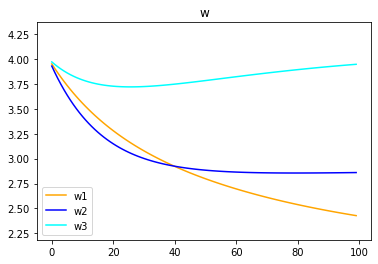

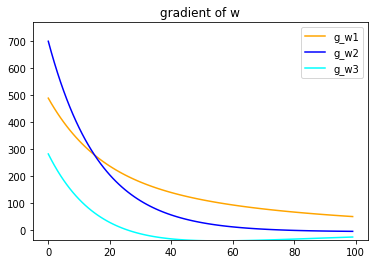

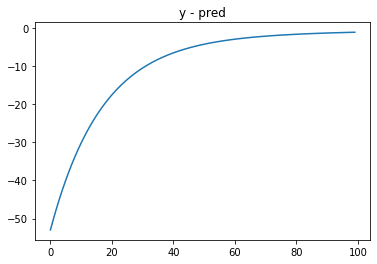

In [377]:
# y=w1x1+w2x2+w3x3
use_opt = False
np.random.seed(2020)
lr=0.0001
sample_cnt=4
fnc = lambda x1,x2,x3: 2*x1+3*x2+4*x3
x = np.random.randint(0,10,(sample_cnt,3)).astype(np.float64)
w = np.random.randint(1,5,(3,)).reshape(-1,1).astype(np.float64)
y = np.array([fnc(*i) for i in x]).reshape(-1,1)
x = tf.Variable(x,trainable=False,name="x")
w = tf.Variable(w,trainable=True,name="w")
y = tf.Variable(y,trainable=False,name="y")
"x",x.numpy()
"y",y.numpy()
"w",w.numpy()
w_history = []
g_history = []
loss_history=[]
opt = tf.keras.optimizers.Adam(learning_rate=1e-1)
for i in tqdm(range(100)):
    with tf.GradientTape() as tape:
        tape.watch(w)
        pred = tf.matmul(x,w)
        loss = tf.keras.losses.MSE(y,pred)
    g = tape.gradient(loss,w)
    g_manually = -2*(y-pred)*x
    loss_history.append(np.sum(y-pred))
    if use_opt:
        _ = opt.apply_gradients(zip([g],[w]))
    else:
        w = w - lr*g
    g_history.append(g.numpy().flatten())
    w_history.append(w.numpy().flatten())
g_history = np.array(g_history)
w_history = np.array(w_history)


# plot W
_ = plt.plot(w_history[:,0],color='orange',label='w1')
_ = plt.plot(w_history[:,1],color='blue',label='w2')
_ = plt.plot(w_history[:,2],color='cyan',label='w3')
_ = plt.legend()
_ = plt.ylim(bottom=np.min(w_history)*0.9,top=np.max(w_history)*1.1)
_ = plt.title("w")
plt.show()


# plot Gradient
_ = plt.plot(g_history[:,0],color='orange',label='g_w1')
_ = plt.plot(g_history[:,1],color='blue',label='g_w2')
_ = plt.plot(g_history[:,2],color='cyan',label='g_w3')
_ = plt.legend()
_ = plt.ylim(bottom=np.min(g_history)*0.9,top=np.max(g_history)*1.1)
_ = plt.title("gradient of w")
plt.show()

# plot loss=y - pred
_ = plt.plot(loss_history)
_ = plt.title("y - pred")
plt.show()

## feature_column

feature_column处理单独一列

In [125]:
na_fill_dict = {f:0 for f in num_feat}
na_fill_dict.update({f:"nan" for f in cat_feat})
chunk_fillna = chunk.fillna(na_fill_dict)
f="C28"
print(">>> featureMap:")
",".join(cat_featureMap[f])
# tfc=tf.feature_column.categorical_column_with_vocabulary_list(key=f,vocabulary_list=cat_featureMap[f])
tfc=tf.feature_column.sequence_categorical_column_with_vocabulary_list(key=f,vocabulary_list=cat_featureMap[f])
tfc=tf.feature_column.indicator_column(tfc)
print(">>> original:")
chunk_fillna[f]
print(">>> feature_columned:")
tf.keras.experimental.SequenceFeatures(tfc)(dict(chunk_fillna))


>>> featureMap:


'2,36,19,20,85,84,42,63,38,48,97,66,88,78,15,22,61,23,72,75,76,98,95,87,54,91,58,6,93,14,65,7,46,18,100,17,44,40,43,86,1,82,45,25,57,13,79,90,39,74,77,8,89,96,70,80,99,3,52,41,81,69,37,31,59,26,47,34,35,92,49,50,53,94,21,71,56,12,24,9,32,67,11,27,5,62,60,29,51,30,55,0,73,68,83,10,4,28,64,16,33'

>>> original:


599000     [63, 41, 65, 80, 70, 49, 57, 94, 27, 46, 56, 69]
599001    [4, 38, 11, 43, 29, 11, 50, 43, 67, 25, 1, 1, ...
599002    [89, 98, 6, 5, 49, 64, 85, 19, 93, 47, 73, 87,...
599003    [87, 8, 71, 9, 84, 24, 100, 65, 8, 99, 60, 87,...
599004    [43, 76, 95, 75, 45, 98, 67, 8, 14, 51, 17, 44...
                                ...                        
599995    [6, 35, 49, 38, 56, 0, 5, 98, 55, 44, 87, 68, ...
599996                          [81, 92, 6, 14, 63, 31, 45]
599997    [80, 62, 92, 31, 51, 36, 22, 44, 18, 34, 95, 5...
599998                                                 [25]
599999    [71, 38, 67, 73, 14, 40, 3, 44, 69, 87, 20, 78...
Name: C28, Length: 1000, dtype: object

>>> feature_columned:


ValueError: Can't convert non-rectangular Python sequence to Tensor.

## Custom Embedding Lookup

In [228]:
multihot_sparse = sp_tensor_list[1]
tf.nn.embedding_lookup(params=M.fm_emb,ids=multihot_sparse.values)
tf.nn.embedding_lookup_sparse(params=M.fm_emb,sp_ids=sp_tensor_list[0],sp_weights=None,combiner="mean")
tf.nn.embedding_lookup_sparse(params=M.fm_emb,sp_ids=sp_tensor_list[1],sp_weights=None,combiner="mean")

<tf.Tensor: shape=(3376, 4), dtype=float64, numpy=
array([[ 2.00076738e-03, -1.66938190e-03,  1.96094384e-03,
        -2.17433416e-03],
       [-3.04468341e-04, -1.02538260e-04,  1.23791813e-03,
         1.66362127e-03],
       [-2.52451650e-03, -7.69125247e-04, -1.15973723e-03,
         6.60721851e-04],
       ...,
       [-1.59397120e-03,  5.35684171e-04,  5.27355848e-05,
         1.72061028e-03],
       [ 7.86939315e-04, -2.44646838e-03, -2.19798721e-03,
         1.39865879e-03],
       [-1.36939802e-04, -2.03143836e-03,  6.35664960e-04,
        -4.19421690e-04]])>

<tf.Tensor: shape=(341, 4), dtype=float64, numpy=
array([[-2.69064183e-04, -5.21357485e-05, -1.55130023e-04,
        -2.37630000e-05],
       [ 2.48563584e-04,  1.39643976e-04,  9.58589066e-06,
         1.97786267e-04],
       [-3.62223776e-05,  1.58399234e-04, -5.98115319e-05,
        -5.39664499e-05],
       ...,
       [-3.08652133e-04, -8.11051590e-06, -5.49057017e-05,
         1.77924917e-05],
       [-1.75004790e-04, -1.59730090e-04,  2.42082631e-04,
        -3.78833239e-04],
       [-3.21719650e-04,  2.67135174e-04,  2.79550813e-04,
        -9.11520983e-05]])>

<tf.Tensor: shape=(340, 4), dtype=float64, numpy=
array([[-1.68139194e-05, -2.56742443e-04, -5.35781567e-04,
         6.07935337e-04],
       [-5.02708935e-05, -2.16739308e-04, -4.52237156e-04,
         9.08683770e-05],
       [-1.54491083e-04, -3.45392266e-04, -3.46641676e-04,
         5.36590049e-06],
       ...,
       [-4.63030444e-05,  5.43878383e-04, -3.08475267e-04,
         3.33819764e-04],
       [ 3.47294193e-04, -4.29777664e-05, -2.27120495e-04,
         7.02353703e-04],
       [ 6.78620270e-05, -8.04858576e-04, -9.91656688e-04,
         1.45940236e-04]])>

In [123]:
tf.keras.layers.DenseFeatures
tf.keras.experimental.SequenceFeatures

tensorflow.python.feature_column.dense_features_v2.DenseFeatures

tensorflow.python.feature_column.sequence_feature_column.SequenceFeatures